##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-10-27 06:06:38.580862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 06:06:38.580905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 06:06:38.582437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

     8192/228813984 [..............................] - ETA: 0s

  8052736/228813984 [>.............................] - ETA: 1s

  8396800/228813984 [>.............................] - ETA: 2s

 20340736/228813984 [=>............................] - ETA: 1s

 31850496/228813984 [===>..........................] - ETA: 1s

 33562624/228813984 [===>..........................] - ETA: 1s

 45211648/228813984 [====>.........................] - ETA: 1s

 56483840/228813984 [======>.......................] - ETA: 1s

 65134592/228813984 [=======>......................] - ETA: 1s

 75161600/228813984 [========>.....................] - ETA: 0s

 87343104/228813984 [==========>...................] - ETA: 0s

 97312768/228813984 [===========>..................] - ETA: 0s

108814336/228813984 [=============>................] - ETA: 0s

120258560/228813984 [==============>...............] - ETA: 0s

131702784/228813984 [================>.............] - ETA: 0s

142860288/228813984 [=================>............] - ETA: 0s

153755648/228813984 [===================>..........] - ETA: 0s

163536896/228813984 [====================>.........] - ETA: 0s

175587328/228813984 [======================>.......] - ETA: 0s

185466880/228813984 [=======================>......] - ETA: 0s

195895296/228813984 [========================>.....] - ETA: 0s

206422016/228813984 [==========================>...] - ETA: 0s

216424448/228813984 [===========================>..] - ETA: 0s

227467264/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

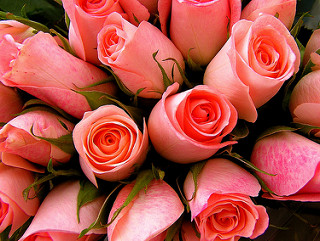

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

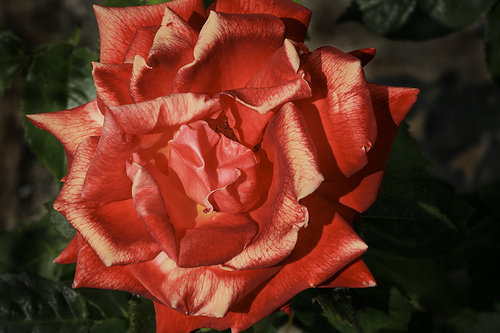

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

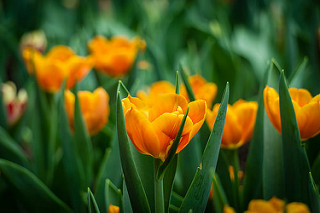

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

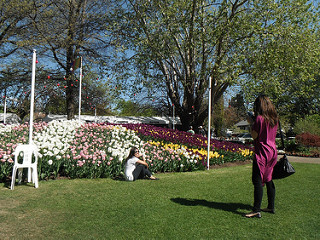

In [8]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

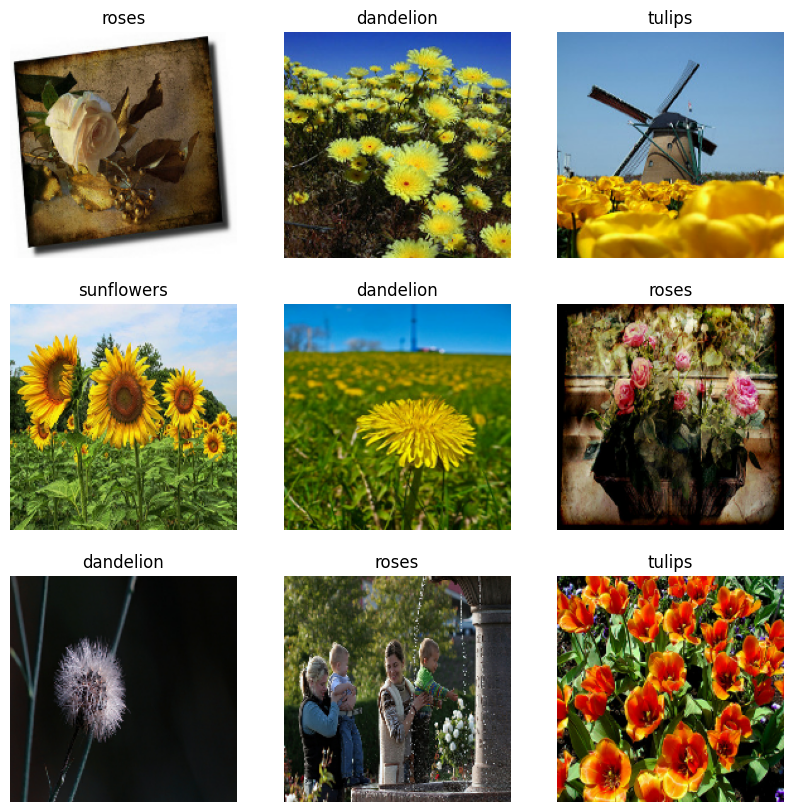

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [20]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d (Conv2D)             (None, 180, 180, 16)      448       


 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         


 D)                                                              


 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 flatten (Flatten)           (None, 30976)             0         


 dense (Dense)               (None, 128)               3965056   


 dense_1 (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1698386810.987968  496306 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/92 [..............................] - ETA: 5:17 - loss: 1.6055 - accuracy: 0.2188

 4/92 [>.............................] - ETA: 1s - loss: 1.7724 - accuracy: 0.2188  

 7/92 [=>............................] - ETA: 1s - loss: 1.6777 - accuracy: 0.1920

10/92 [==>...........................] - ETA: 1s - loss: 1.6403 - accuracy: 0.2250

13/92 [===>..........................] - ETA: 1s - loss: 1.6072 - accuracy: 0.2524

16/92 [====>.........................] - ETA: 1s - loss: 1.5801 - accuracy: 0.2773

19/92 [=====>........................] - ETA: 1s - loss: 1.5526 - accuracy: 0.2961

22/92 [======>.......................] - ETA: 1s - loss: 1.5365 - accuracy: 0.3054

25/92 [=======>......................] - ETA: 1s - loss: 1.5105 - accuracy: 0.3187

28/92 [========>.....................] - ETA: 1s - loss: 1.4845 - accuracy: 0.3337

31/92 [=========>....................] - ETA: 1s - loss: 1.4774 - accuracy: 0.3296

34/92 [==========>...................] - ETA: 1s - loss: 1.4726 - accuracy: 0.3355

37/92 [===========>..................] - ETA: 0s - loss: 1.4572 - accuracy: 0.3471

40/92 [============>.................] - ETA: 0s - loss: 1.4413 - accuracy: 0.3562

43/92 [=============>................] - ETA: 0s - loss: 1.4212 - accuracy: 0.3714

46/92 [==============>...............] - ETA: 0s - loss: 1.4057 - accuracy: 0.3777

49/92 [==============>...............] - ETA: 0s - loss: 1.3915 - accuracy: 0.3846

52/92 [===============>..............] - ETA: 0s - loss: 1.3802 - accuracy: 0.3912

55/92 [================>.............] - ETA: 0s - loss: 1.3725 - accuracy: 0.3966

58/92 [=================>............] - ETA: 0s - loss: 1.3594 - accuracy: 0.4041

61/92 [==================>...........] - ETA: 0s - loss: 1.3422 - accuracy: 0.4134

64/92 [===================>..........] - ETA: 0s - loss: 1.3349 - accuracy: 0.4189

67/92 [====================>.........] - ETA: 0s - loss: 1.3222 - accuracy: 0.4268

68/92 [=====================>........] - ETA: 0s - loss: 1.3201 - accuracy: 0.4285

71/92 [======================>.......] - ETA: 0s - loss: 1.3108 - accuracy: 0.4311

74/92 [=======================>......] - ETA: 0s - loss: 1.3042 - accuracy: 0.4364

77/92 [========================>.....] - ETA: 0s - loss: 1.2986 - accuracy: 0.4381

80/92 [=========================>....] - ETA: 0s - loss: 1.2882 - accuracy: 0.4432

83/92 [==========================>...] - ETA: 0s - loss: 1.2828 - accuracy: 0.4471

86/92 [===========================>..] - ETA: 0s - loss: 1.2786 - accuracy: 0.4490

89/92 [============================>.] - ETA: 0s - loss: 1.2762 - accuracy: 0.4511

92/92 [==============================] - ETA: 0s - loss: 1.2684 - accuracy: 0.4554

92/92 [==============================] - 6s 33ms/step - loss: 1.2684 - accuracy: 0.4554 - val_loss: 1.1000 - val_accuracy: 0.5341


Epoch 2/10


 1/92 [..............................] - ETA: 1s - loss: 0.9957 - accuracy: 0.6250

 4/92 [>.............................] - ETA: 1s - loss: 0.8548 - accuracy: 0.6719

 7/92 [=>............................] - ETA: 1s - loss: 0.9303 - accuracy: 0.6518

10/92 [==>...........................] - ETA: 1s - loss: 0.9273 - accuracy: 0.6442

13/92 [===>..........................] - ETA: 1s - loss: 0.9573 - accuracy: 0.6422

16/92 [====>.........................] - ETA: 1s - loss: 0.9541 - accuracy: 0.6329

19/92 [=====>........................] - ETA: 1s - loss: 0.9803 - accuracy: 0.6150

22/92 [======>.......................] - ETA: 1s - loss: 0.9970 - accuracy: 0.6020

25/92 [=======>......................] - ETA: 1s - loss: 0.9960 - accuracy: 0.5985

28/92 [========>.....................] - ETA: 1s - loss: 0.9969 - accuracy: 0.6047

31/92 [=========>....................] - ETA: 1s - loss: 0.9838 - accuracy: 0.6159

34/92 [==========>...................] - ETA: 1s - loss: 0.9767 - accuracy: 0.6157

37/92 [===========>..................] - ETA: 0s - loss: 0.9812 - accuracy: 0.6114

40/92 [============>.................] - ETA: 0s - loss: 0.9772 - accuracy: 0.6132

43/92 [=============>................] - ETA: 0s - loss: 0.9790 - accuracy: 0.6089

46/92 [==============>...............] - ETA: 0s - loss: 0.9730 - accuracy: 0.6120

49/92 [==============>...............] - ETA: 0s - loss: 0.9732 - accuracy: 0.6135

52/92 [===============>..............] - ETA: 0s - loss: 0.9678 - accuracy: 0.6178

55/92 [================>.............] - ETA: 0s - loss: 0.9678 - accuracy: 0.6193

58/92 [=================>............] - ETA: 0s - loss: 0.9625 - accuracy: 0.6212

61/92 [==================>...........] - ETA: 0s - loss: 0.9591 - accuracy: 0.6214

64/92 [===================>..........] - ETA: 0s - loss: 0.9554 - accuracy: 0.6211

67/92 [====================>.........] - ETA: 0s - loss: 0.9475 - accuracy: 0.6269

70/92 [=====================>........] - ETA: 0s - loss: 0.9462 - accuracy: 0.6268

73/92 [======================>.......] - ETA: 0s - loss: 0.9481 - accuracy: 0.6241

76/92 [=======================>......] - ETA: 0s - loss: 0.9483 - accuracy: 0.6233

79/92 [========================>.....] - ETA: 0s - loss: 0.9437 - accuracy: 0.6246

82/92 [=========================>....] - ETA: 0s - loss: 0.9363 - accuracy: 0.6273

85/92 [==========================>...] - ETA: 0s - loss: 0.9331 - accuracy: 0.6305

88/92 [===========================>..] - ETA: 0s - loss: 0.9312 - accuracy: 0.6325

91/92 [============================>.] - ETA: 0s - loss: 0.9276 - accuracy: 0.6350

92/92 [==============================] - 2s 20ms/step - loss: 0.9320 - accuracy: 0.6339 - val_loss: 0.9423 - val_accuracy: 0.6104


Epoch 3/10


 1/92 [..............................] - ETA: 1s - loss: 1.0376 - accuracy: 0.6250

 4/92 [>.............................] - ETA: 1s - loss: 0.7823 - accuracy: 0.7109

 7/92 [=>............................] - ETA: 1s - loss: 0.7523 - accuracy: 0.7232

10/92 [==>...........................] - ETA: 1s - loss: 0.7852 - accuracy: 0.6906

13/92 [===>..........................] - ETA: 1s - loss: 0.7937 - accuracy: 0.6789

16/92 [====>.........................] - ETA: 1s - loss: 0.7805 - accuracy: 0.6825

19/92 [=====>........................] - ETA: 1s - loss: 0.8128 - accuracy: 0.6733

22/92 [======>.......................] - ETA: 1s - loss: 0.8003 - accuracy: 0.6782

25/92 [=======>......................] - ETA: 1s - loss: 0.8115 - accuracy: 0.6780

28/92 [========>.....................] - ETA: 1s - loss: 0.8199 - accuracy: 0.6813

31/92 [=========>....................] - ETA: 1s - loss: 0.8123 - accuracy: 0.6850

34/92 [==========>...................] - ETA: 1s - loss: 0.7995 - accuracy: 0.6926

37/92 [===========>..................] - ETA: 0s - loss: 0.7939 - accuracy: 0.6964

40/92 [============>.................] - ETA: 0s - loss: 0.7894 - accuracy: 0.6989

43/92 [=============>................] - ETA: 0s - loss: 0.7892 - accuracy: 0.6974

46/92 [==============>...............] - ETA: 0s - loss: 0.7865 - accuracy: 0.6988

49/92 [==============>...............] - ETA: 0s - loss: 0.7787 - accuracy: 0.7051

52/92 [===============>..............] - ETA: 0s - loss: 0.7748 - accuracy: 0.7029

55/92 [================>.............] - ETA: 0s - loss: 0.7712 - accuracy: 0.7038

58/92 [=================>............] - ETA: 0s - loss: 0.7707 - accuracy: 0.7035

61/92 [==================>...........] - ETA: 0s - loss: 0.7620 - accuracy: 0.7083

64/92 [===================>..........] - ETA: 0s - loss: 0.7576 - accuracy: 0.7103

67/92 [====================>.........] - ETA: 0s - loss: 0.7547 - accuracy: 0.7116

70/92 [=====================>........] - ETA: 0s - loss: 0.7508 - accuracy: 0.7137

73/92 [======================>.......] - ETA: 0s - loss: 0.7441 - accuracy: 0.7161

76/92 [=======================>......] - ETA: 0s - loss: 0.7433 - accuracy: 0.7145

79/92 [========================>.....] - ETA: 0s - loss: 0.7355 - accuracy: 0.7190

82/92 [=========================>....] - ETA: 0s - loss: 0.7365 - accuracy: 0.7179

85/92 [==========================>...] - ETA: 0s - loss: 0.7358 - accuracy: 0.7179

88/92 [===========================>..] - ETA: 0s - loss: 0.7330 - accuracy: 0.7187

91/92 [============================>.] - ETA: 0s - loss: 0.7285 - accuracy: 0.7204

92/92 [==============================] - 2s 20ms/step - loss: 0.7276 - accuracy: 0.7204 - val_loss: 0.9055 - val_accuracy: 0.6499


Epoch 4/10


 1/92 [..............................] - ETA: 1s - loss: 0.7360 - accuracy: 0.6875

 4/92 [>.............................] - ETA: 1s - loss: 0.5580 - accuracy: 0.7656

 7/92 [=>............................] - ETA: 1s - loss: 0.5686 - accuracy: 0.7679

10/92 [==>...........................] - ETA: 1s - loss: 0.5413 - accuracy: 0.7875

13/92 [===>..........................] - ETA: 1s - loss: 0.5160 - accuracy: 0.8053

16/92 [====>.........................] - ETA: 1s - loss: 0.4971 - accuracy: 0.8164

19/92 [=====>........................] - ETA: 1s - loss: 0.4853 - accuracy: 0.8273

22/92 [======>.......................] - ETA: 1s - loss: 0.5013 - accuracy: 0.8253

25/92 [=======>......................] - ETA: 1s - loss: 0.5020 - accuracy: 0.8238

28/92 [========>.....................] - ETA: 1s - loss: 0.5030 - accuracy: 0.8192

31/92 [=========>....................] - ETA: 1s - loss: 0.5228 - accuracy: 0.8065

34/92 [==========>...................] - ETA: 1s - loss: 0.5171 - accuracy: 0.8061

37/92 [===========>..................] - ETA: 0s - loss: 0.5128 - accuracy: 0.8057

40/92 [============>.................] - ETA: 0s - loss: 0.5091 - accuracy: 0.8094

43/92 [=============>................] - ETA: 0s - loss: 0.4960 - accuracy: 0.8154

46/92 [==============>...............] - ETA: 0s - loss: 0.5063 - accuracy: 0.8118

49/92 [==============>...............] - ETA: 0s - loss: 0.5061 - accuracy: 0.8112

52/92 [===============>..............] - ETA: 0s - loss: 0.5057 - accuracy: 0.8107

55/92 [================>.............] - ETA: 0s - loss: 0.5028 - accuracy: 0.8136

58/92 [=================>............] - ETA: 0s - loss: 0.5039 - accuracy: 0.8103

61/92 [==================>...........] - ETA: 0s - loss: 0.5034 - accuracy: 0.8081

64/92 [===================>..........] - ETA: 0s - loss: 0.5036 - accuracy: 0.8088

67/92 [====================>.........] - ETA: 0s - loss: 0.5013 - accuracy: 0.8099

70/92 [=====================>........] - ETA: 0s - loss: 0.5043 - accuracy: 0.8082

73/92 [======================>.......] - ETA: 0s - loss: 0.5084 - accuracy: 0.8071

76/92 [=======================>......] - ETA: 0s - loss: 0.5093 - accuracy: 0.8061

79/92 [========================>.....] - ETA: 0s - loss: 0.5081 - accuracy: 0.8071

82/92 [=========================>....] - ETA: 0s - loss: 0.5073 - accuracy: 0.8085

85/92 [==========================>...] - ETA: 0s - loss: 0.5061 - accuracy: 0.8083

88/92 [===========================>..] - ETA: 0s - loss: 0.5070 - accuracy: 0.8088

91/92 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.8085

92/92 [==============================] - 2s 20ms/step - loss: 0.5049 - accuracy: 0.8093 - val_loss: 1.0202 - val_accuracy: 0.6308


Epoch 5/10


 1/92 [..............................] - ETA: 1s - loss: 0.2680 - accuracy: 0.9688

 4/92 [>.............................] - ETA: 1s - loss: 0.2464 - accuracy: 0.9531

 7/92 [=>............................] - ETA: 1s - loss: 0.2793 - accuracy: 0.9420

10/92 [==>...........................] - ETA: 1s - loss: 0.2636 - accuracy: 0.9406

13/92 [===>..........................] - ETA: 1s - loss: 0.2840 - accuracy: 0.9255

16/92 [====>.........................] - ETA: 1s - loss: 0.2953 - accuracy: 0.9180

19/92 [=====>........................] - ETA: 1s - loss: 0.3003 - accuracy: 0.9062

22/92 [======>.......................] - ETA: 1s - loss: 0.2868 - accuracy: 0.9119

25/92 [=======>......................] - ETA: 1s - loss: 0.2902 - accuracy: 0.9062

28/92 [========>.....................] - ETA: 1s - loss: 0.2902 - accuracy: 0.9074

31/92 [=========>....................] - ETA: 1s - loss: 0.2881 - accuracy: 0.9083

34/92 [==========>...................] - ETA: 1s - loss: 0.2902 - accuracy: 0.9062

37/92 [===========>..................] - ETA: 0s - loss: 0.2959 - accuracy: 0.9037

40/92 [============>.................] - ETA: 0s - loss: 0.2944 - accuracy: 0.9047

43/92 [=============>................] - ETA: 0s - loss: 0.2931 - accuracy: 0.9026

46/92 [==============>...............] - ETA: 0s - loss: 0.2978 - accuracy: 0.9003

49/92 [==============>...............] - ETA: 0s - loss: 0.2942 - accuracy: 0.9032

52/92 [===============>..............] - ETA: 0s - loss: 0.2951 - accuracy: 0.9028

55/92 [================>.............] - ETA: 0s - loss: 0.2949 - accuracy: 0.9030

58/92 [=================>............] - ETA: 0s - loss: 0.3018 - accuracy: 0.8994

61/92 [==================>...........] - ETA: 0s - loss: 0.3087 - accuracy: 0.8956

64/92 [===================>..........] - ETA: 0s - loss: 0.3081 - accuracy: 0.8946

67/92 [====================>.........] - ETA: 0s - loss: 0.3063 - accuracy: 0.8965

70/92 [=====================>........] - ETA: 0s - loss: 0.3065 - accuracy: 0.8965

73/92 [======================>.......] - ETA: 0s - loss: 0.3113 - accuracy: 0.8930

76/92 [=======================>......] - ETA: 0s - loss: 0.3100 - accuracy: 0.8948

79/92 [========================>.....] - ETA: 0s - loss: 0.3087 - accuracy: 0.8948

82/92 [=========================>....] - ETA: 0s - loss: 0.3073 - accuracy: 0.8945

85/92 [==========================>...] - ETA: 0s - loss: 0.3060 - accuracy: 0.8945

88/92 [===========================>..] - ETA: 0s - loss: 0.3062 - accuracy: 0.8949

91/92 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8946

92/92 [==============================] - 2s 20ms/step - loss: 0.3051 - accuracy: 0.8944 - val_loss: 1.1178 - val_accuracy: 0.6703


Epoch 6/10


 1/92 [..............................] - ETA: 1s - loss: 0.2200 - accuracy: 0.9062

 4/92 [>.............................] - ETA: 1s - loss: 0.1870 - accuracy: 0.9453

 7/92 [=>............................] - ETA: 1s - loss: 0.1519 - accuracy: 0.9598

10/92 [==>...........................] - ETA: 1s - loss: 0.1701 - accuracy: 0.9500

13/92 [===>..........................] - ETA: 1s - loss: 0.1569 - accuracy: 0.9519

16/92 [====>.........................] - ETA: 1s - loss: 0.1508 - accuracy: 0.9551

19/92 [=====>........................] - ETA: 1s - loss: 0.1457 - accuracy: 0.9556

22/92 [======>.......................] - ETA: 1s - loss: 0.1409 - accuracy: 0.9574

25/92 [=======>......................] - ETA: 1s - loss: 0.1391 - accuracy: 0.9600

28/92 [========>.....................] - ETA: 1s - loss: 0.1377 - accuracy: 0.9583

31/92 [=========>....................] - ETA: 1s - loss: 0.1378 - accuracy: 0.9583

34/92 [==========>...................] - ETA: 1s - loss: 0.1409 - accuracy: 0.9593

37/92 [===========>..................] - ETA: 0s - loss: 0.1355 - accuracy: 0.9617

40/92 [============>.................] - ETA: 0s - loss: 0.1351 - accuracy: 0.9631

43/92 [=============>................] - ETA: 0s - loss: 0.1371 - accuracy: 0.9613

46/92 [==============>...............] - ETA: 0s - loss: 0.1361 - accuracy: 0.9611

49/92 [==============>...............] - ETA: 0s - loss: 0.1338 - accuracy: 0.9622

52/92 [===============>..............] - ETA: 0s - loss: 0.1342 - accuracy: 0.9614

55/92 [================>.............] - ETA: 0s - loss: 0.1312 - accuracy: 0.9623

58/92 [=================>............] - ETA: 0s - loss: 0.1304 - accuracy: 0.9616

61/92 [==================>...........] - ETA: 0s - loss: 0.1306 - accuracy: 0.9609

64/92 [===================>..........] - ETA: 0s - loss: 0.1377 - accuracy: 0.9593

67/92 [====================>.........] - ETA: 0s - loss: 0.1393 - accuracy: 0.9579

70/92 [=====================>........] - ETA: 0s - loss: 0.1417 - accuracy: 0.9565

73/92 [======================>.......] - ETA: 0s - loss: 0.1408 - accuracy: 0.9566

76/92 [=======================>......] - ETA: 0s - loss: 0.1392 - accuracy: 0.9575

79/92 [========================>.....] - ETA: 0s - loss: 0.1402 - accuracy: 0.9567

82/92 [=========================>....] - ETA: 0s - loss: 0.1410 - accuracy: 0.9564

85/92 [==========================>...] - ETA: 0s - loss: 0.1410 - accuracy: 0.9561

88/92 [===========================>..] - ETA: 0s - loss: 0.1401 - accuracy: 0.9566

91/92 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9556

92/92 [==============================] - 2s 20ms/step - loss: 0.1447 - accuracy: 0.9544 - val_loss: 1.3535 - val_accuracy: 0.6458


Epoch 7/10


 1/92 [..............................] - ETA: 1s - loss: 0.1267 - accuracy: 0.9688

 4/92 [>.............................] - ETA: 1s - loss: 0.1008 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 1s - loss: 0.0948 - accuracy: 0.9732

10/92 [==>...........................] - ETA: 1s - loss: 0.0917 - accuracy: 0.9719

13/92 [===>..........................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9736

16/92 [====>.........................] - ETA: 1s - loss: 0.0908 - accuracy: 0.9727

19/92 [=====>........................] - ETA: 1s - loss: 0.0947 - accuracy: 0.9753

22/92 [======>.......................] - ETA: 1s - loss: 0.0895 - accuracy: 0.9773

25/92 [=======>......................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9762

28/92 [========>.....................] - ETA: 1s - loss: 0.0916 - accuracy: 0.9754

31/92 [=========>....................] - ETA: 1s - loss: 0.0922 - accuracy: 0.9768

34/92 [==========>...................] - ETA: 1s - loss: 0.0891 - accuracy: 0.9779

37/92 [===========>..................] - ETA: 0s - loss: 0.0885 - accuracy: 0.9789

40/92 [============>.................] - ETA: 0s - loss: 0.0852 - accuracy: 0.9797

43/92 [=============>................] - ETA: 0s - loss: 0.0893 - accuracy: 0.9789

46/92 [==============>...............] - ETA: 0s - loss: 0.0872 - accuracy: 0.9796

49/92 [==============>...............] - ETA: 0s - loss: 0.0864 - accuracy: 0.9790

52/92 [===============>..............] - ETA: 0s - loss: 0.0887 - accuracy: 0.9771

55/92 [================>.............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9783

58/92 [=================>............] - ETA: 0s - loss: 0.0849 - accuracy: 0.9794

61/92 [==================>...........] - ETA: 0s - loss: 0.0842 - accuracy: 0.9805

64/92 [===================>..........] - ETA: 0s - loss: 0.0827 - accuracy: 0.9809

67/92 [====================>.........] - ETA: 0s - loss: 0.0835 - accuracy: 0.9803

70/92 [=====================>........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9794

73/92 [======================>.......] - ETA: 0s - loss: 0.0843 - accuracy: 0.9802

76/92 [=======================>......] - ETA: 0s - loss: 0.0828 - accuracy: 0.9802

79/92 [========================>.....] - ETA: 0s - loss: 0.0814 - accuracy: 0.9810

82/92 [=========================>....] - ETA: 0s - loss: 0.0815 - accuracy: 0.9805

85/92 [==========================>...] - ETA: 0s - loss: 0.0797 - accuracy: 0.9808

88/92 [===========================>..] - ETA: 0s - loss: 0.0795 - accuracy: 0.9808

91/92 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9811

92/92 [==============================] - 2s 20ms/step - loss: 0.0780 - accuracy: 0.9813 - val_loss: 1.4593 - val_accuracy: 0.6444


Epoch 8/10


 1/92 [..............................] - ETA: 1s - loss: 0.0093 - accuracy: 1.0000

 4/92 [>.............................] - ETA: 1s - loss: 0.0389 - accuracy: 0.9922

 7/92 [=>............................] - ETA: 1s - loss: 0.0449 - accuracy: 0.9866

10/92 [==>...........................] - ETA: 1s - loss: 0.0438 - accuracy: 0.9844

13/92 [===>..........................] - ETA: 1s - loss: 0.0407 - accuracy: 0.9856

16/92 [====>.........................] - ETA: 1s - loss: 0.0372 - accuracy: 0.9863

19/92 [=====>........................] - ETA: 1s - loss: 0.0346 - accuracy: 0.9885

22/92 [======>.......................] - ETA: 1s - loss: 0.0454 - accuracy: 0.9872

25/92 [=======>......................] - ETA: 1s - loss: 0.0450 - accuracy: 0.9875

28/92 [========>.....................] - ETA: 1s - loss: 0.0492 - accuracy: 0.9866

31/92 [=========>....................] - ETA: 1s - loss: 0.0474 - accuracy: 0.9869

34/92 [==========>...................] - ETA: 1s - loss: 0.0500 - accuracy: 0.9844

37/92 [===========>..................] - ETA: 0s - loss: 0.0477 - accuracy: 0.9848

40/92 [============>.................] - ETA: 0s - loss: 0.0461 - accuracy: 0.9852

43/92 [=============>................] - ETA: 0s - loss: 0.0462 - accuracy: 0.9847

46/92 [==============>...............] - ETA: 0s - loss: 0.0445 - accuracy: 0.9857

49/92 [==============>...............] - ETA: 0s - loss: 0.0429 - accuracy: 0.9866

52/92 [===============>..............] - ETA: 0s - loss: 0.0414 - accuracy: 0.9874

55/92 [================>.............] - ETA: 0s - loss: 0.0406 - accuracy: 0.9881

58/92 [=================>............] - ETA: 0s - loss: 0.0401 - accuracy: 0.9881

61/92 [==================>...........] - ETA: 0s - loss: 0.0400 - accuracy: 0.9887

64/92 [===================>..........] - ETA: 0s - loss: 0.0395 - accuracy: 0.9888

67/92 [====================>.........] - ETA: 0s - loss: 0.0388 - accuracy: 0.9893

70/92 [=====================>........] - ETA: 0s - loss: 0.0388 - accuracy: 0.9888

73/92 [======================>.......] - ETA: 0s - loss: 0.0395 - accuracy: 0.9884

76/92 [=======================>......] - ETA: 0s - loss: 0.0388 - accuracy: 0.9889

79/92 [========================>.....] - ETA: 0s - loss: 0.0385 - accuracy: 0.9889

82/92 [=========================>....] - ETA: 0s - loss: 0.0387 - accuracy: 0.9889

85/92 [==========================>...] - ETA: 0s - loss: 0.0407 - accuracy: 0.9878

88/92 [===========================>..] - ETA: 0s - loss: 0.0413 - accuracy: 0.9875

91/92 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9876

92/92 [==============================] - 2s 20ms/step - loss: 0.0431 - accuracy: 0.9871 - val_loss: 1.8759 - val_accuracy: 0.6185


Epoch 9/10


 1/92 [..............................] - ETA: 1s - loss: 0.0468 - accuracy: 1.0000

 4/92 [>.............................] - ETA: 1s - loss: 0.0353 - accuracy: 0.9844

 7/92 [=>............................] - ETA: 1s - loss: 0.0317 - accuracy: 0.9911

10/92 [==>...........................] - ETA: 1s - loss: 0.0415 - accuracy: 0.9875

13/92 [===>..........................] - ETA: 1s - loss: 0.0377 - accuracy: 0.9904

16/92 [====>.........................] - ETA: 1s - loss: 0.0358 - accuracy: 0.9922

19/92 [=====>........................] - ETA: 1s - loss: 0.0346 - accuracy: 0.9918

22/92 [======>.......................] - ETA: 1s - loss: 0.0330 - accuracy: 0.9928

25/92 [=======>......................] - ETA: 1s - loss: 0.0331 - accuracy: 0.9912

28/92 [========>.....................] - ETA: 1s - loss: 0.0305 - accuracy: 0.9921

31/92 [=========>....................] - ETA: 1s - loss: 0.0297 - accuracy: 0.9919

34/92 [==========>...................] - ETA: 1s - loss: 0.0289 - accuracy: 0.9926

37/92 [===========>..................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9915

40/92 [============>.................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9921

43/92 [=============>................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9912

46/92 [==============>...............] - ETA: 0s - loss: 0.0279 - accuracy: 0.9918

49/92 [==============>...............] - ETA: 0s - loss: 0.0284 - accuracy: 0.9917

52/92 [===============>..............] - ETA: 0s - loss: 0.0272 - accuracy: 0.9921

55/92 [================>.............] - ETA: 0s - loss: 0.0276 - accuracy: 0.9914

58/92 [=================>............] - ETA: 0s - loss: 0.0270 - accuracy: 0.9913

61/92 [==================>...........] - ETA: 0s - loss: 0.0266 - accuracy: 0.9913

64/92 [===================>..........] - ETA: 0s - loss: 0.0255 - accuracy: 0.9917

67/92 [====================>.........] - ETA: 0s - loss: 0.0247 - accuracy: 0.9920

70/92 [=====================>........] - ETA: 0s - loss: 0.0241 - accuracy: 0.9924

73/92 [======================>.......] - ETA: 0s - loss: 0.0234 - accuracy: 0.9927

76/92 [=======================>......] - ETA: 0s - loss: 0.0234 - accuracy: 0.9926

79/92 [========================>.....] - ETA: 0s - loss: 0.0229 - accuracy: 0.9929

82/92 [=========================>....] - ETA: 0s - loss: 0.0246 - accuracy: 0.9927

85/92 [==========================>...] - ETA: 0s - loss: 0.0251 - accuracy: 0.9923

88/92 [===========================>..] - ETA: 0s - loss: 0.0245 - accuracy: 0.9925

91/92 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9924

92/92 [==============================] - 2s 20ms/step - loss: 0.0257 - accuracy: 0.9918 - val_loss: 1.9615 - val_accuracy: 0.6485


Epoch 10/10


 1/92 [..............................] - ETA: 1s - loss: 0.0215 - accuracy: 1.0000

 4/92 [>.............................] - ETA: 1s - loss: 0.0215 - accuracy: 0.9922

 7/92 [=>............................] - ETA: 1s - loss: 0.0144 - accuracy: 0.9955

10/92 [==>...........................] - ETA: 1s - loss: 0.0137 - accuracy: 0.9969

13/92 [===>..........................] - ETA: 1s - loss: 0.0127 - accuracy: 0.9976

16/92 [====>.........................] - ETA: 1s - loss: 0.0254 - accuracy: 0.9961

19/92 [=====>........................] - ETA: 1s - loss: 0.0251 - accuracy: 0.9951

22/92 [======>.......................] - ETA: 1s - loss: 0.0307 - accuracy: 0.9901

25/92 [=======>......................] - ETA: 1s - loss: 0.0293 - accuracy: 0.9912

28/92 [========>.....................] - ETA: 1s - loss: 0.0349 - accuracy: 0.9877

31/92 [=========>....................] - ETA: 1s - loss: 0.0338 - accuracy: 0.9889

34/92 [==========>...................] - ETA: 1s - loss: 0.0325 - accuracy: 0.9899

37/92 [===========>..................] - ETA: 0s - loss: 0.0362 - accuracy: 0.9882

40/92 [============>.................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9891

43/92 [=============>................] - ETA: 0s - loss: 0.0339 - accuracy: 0.9891

46/92 [==============>...............] - ETA: 0s - loss: 0.0331 - accuracy: 0.9898

49/92 [==============>...............] - ETA: 0s - loss: 0.0322 - accuracy: 0.9904

52/92 [===============>..............] - ETA: 0s - loss: 0.0321 - accuracy: 0.9904

55/92 [================>.............] - ETA: 0s - loss: 0.0312 - accuracy: 0.9909

58/92 [=================>............] - ETA: 0s - loss: 0.0302 - accuracy: 0.9914

61/92 [==================>...........] - ETA: 0s - loss: 0.0292 - accuracy: 0.9918

64/92 [===================>..........] - ETA: 0s - loss: 0.0284 - accuracy: 0.9922

67/92 [====================>.........] - ETA: 0s - loss: 0.0282 - accuracy: 0.9921

70/92 [=====================>........] - ETA: 0s - loss: 0.0277 - accuracy: 0.9924

73/92 [======================>.......] - ETA: 0s - loss: 0.0269 - accuracy: 0.9927

76/92 [=======================>......] - ETA: 0s - loss: 0.0265 - accuracy: 0.9930

79/92 [========================>.....] - ETA: 0s - loss: 0.0258 - accuracy: 0.9933

82/92 [=========================>....] - ETA: 0s - loss: 0.0252 - accuracy: 0.9935

85/92 [==========================>...] - ETA: 0s - loss: 0.0247 - accuracy: 0.9937

88/92 [===========================>..] - ETA: 0s - loss: 0.0245 - accuracy: 0.9936

91/92 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9938

92/92 [==============================] - 2s 20ms/step - loss: 0.0238 - accuracy: 0.9939 - val_loss: 1.9250 - val_accuracy: 0.6512


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

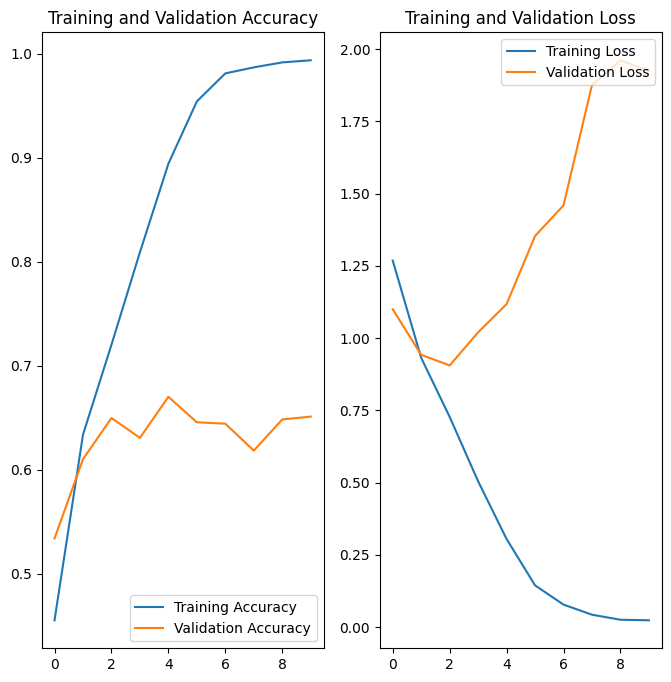

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

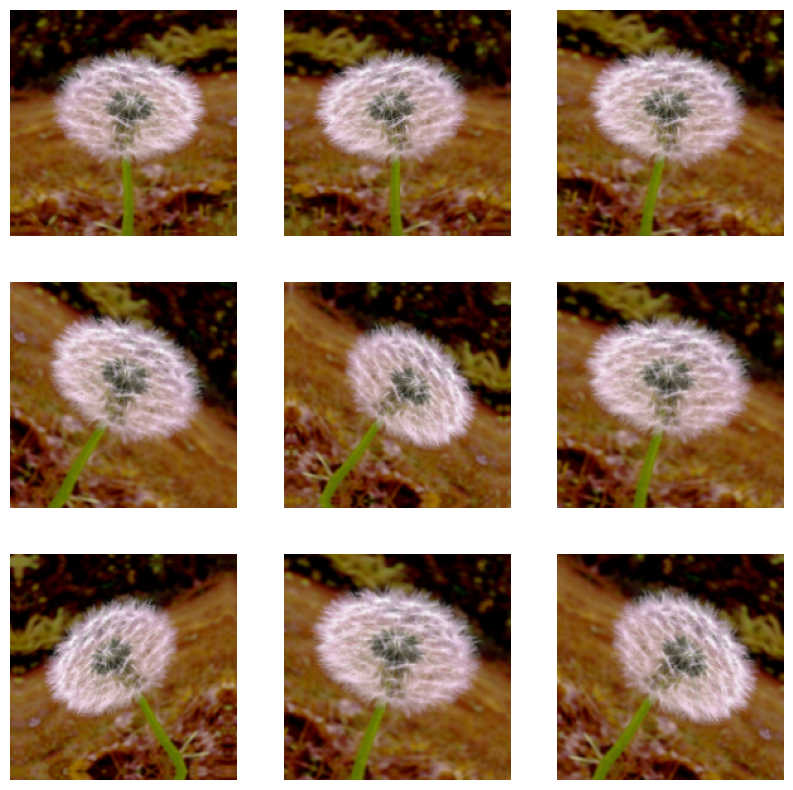

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2023-10-27 06:07:14.991138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1/92 [..............................] - ETA: 3:41 - loss: 1.6378 - accuracy: 0.1562

 3/92 [..............................] - ETA: 3s - loss: 2.4112 - accuracy: 0.1875  

 5/92 [>.............................] - ETA: 3s - loss: 2.1835 - accuracy: 0.2250

 7/92 [=>............................] - ETA: 2s - loss: 2.0205 - accuracy: 0.2277

 9/92 [=>............................] - ETA: 2s - loss: 1.9143 - accuracy: 0.2604

11/92 [==>...........................] - ETA: 2s - loss: 1.8468 - accuracy: 0.2756

13/92 [===>..........................] - ETA: 2s - loss: 1.8019 - accuracy: 0.2692

15/92 [===>..........................] - ETA: 2s - loss: 1.7582 - accuracy: 0.2854

17/92 [====>.........................] - ETA: 2s - loss: 1.7233 - accuracy: 0.2960

19/92 [=====>........................] - ETA: 2s - loss: 1.6947 - accuracy: 0.3158

21/92 [=====>........................] - ETA: 2s - loss: 1.6656 - accuracy: 0.3155

23/92 [======>.......................] - ETA: 2s - loss: 1.6412 - accuracy: 0.3166

25/92 [=======>......................] - ETA: 1s - loss: 1.6215 - accuracy: 0.3225

27/92 [=======>......................] - ETA: 1s - loss: 1.5988 - accuracy: 0.3299

29/92 [========>.....................] - ETA: 1s - loss: 1.5830 - accuracy: 0.3384

31/92 [=========>....................] - ETA: 1s - loss: 1.5723 - accuracy: 0.3427

33/92 [=========>....................] - ETA: 1s - loss: 1.5517 - accuracy: 0.3513

35/92 [==========>...................] - ETA: 1s - loss: 1.5369 - accuracy: 0.3527

37/92 [===========>..................] - ETA: 1s - loss: 1.5183 - accuracy: 0.3623

39/92 [===========>..................] - ETA: 1s - loss: 1.5095 - accuracy: 0.3678

41/92 [============>.................] - ETA: 1s - loss: 1.5044 - accuracy: 0.3620

43/92 [=============>................] - ETA: 1s - loss: 1.4933 - accuracy: 0.3656

45/92 [=============>................] - ETA: 1s - loss: 1.4776 - accuracy: 0.3708

47/92 [==============>...............] - ETA: 1s - loss: 1.4704 - accuracy: 0.3723

49/92 [==============>...............] - ETA: 1s - loss: 1.4614 - accuracy: 0.3750

51/92 [===============>..............] - ETA: 1s - loss: 1.4526 - accuracy: 0.3775

53/92 [================>.............] - ETA: 1s - loss: 1.4442 - accuracy: 0.3815

55/92 [================>.............] - ETA: 1s - loss: 1.4341 - accuracy: 0.3847

57/92 [=================>............] - ETA: 0s - loss: 1.4293 - accuracy: 0.3887

59/92 [==================>...........] - ETA: 0s - loss: 1.4201 - accuracy: 0.3919

61/92 [==================>...........] - ETA: 0s - loss: 1.4106 - accuracy: 0.3940

64/92 [===================>..........] - ETA: 0s - loss: 1.4034 - accuracy: 0.4025

66/92 [====================>.........] - ETA: 0s - loss: 1.3980 - accuracy: 0.4064

68/92 [=====================>........] - ETA: 0s - loss: 1.3859 - accuracy: 0.4142

70/92 [=====================>........] - ETA: 0s - loss: 1.3806 - accuracy: 0.4162

72/92 [======================>.......] - ETA: 0s - loss: 1.3754 - accuracy: 0.4164

74/92 [=======================>......] - ETA: 0s - loss: 1.3669 - accuracy: 0.4220

76/92 [=======================>......] - ETA: 0s - loss: 1.3615 - accuracy: 0.4253

78/92 [========================>.....] - ETA: 0s - loss: 1.3514 - accuracy: 0.4297

80/92 [=========================>....] - ETA: 0s - loss: 1.3470 - accuracy: 0.4322

82/92 [=========================>....] - ETA: 0s - loss: 1.3409 - accuracy: 0.4343

84/92 [==========================>...] - ETA: 0s - loss: 1.3355 - accuracy: 0.4366

86/92 [===========================>..] - ETA: 0s - loss: 1.3312 - accuracy: 0.4384

88/92 [===========================>..] - ETA: 0s - loss: 1.3227 - accuracy: 0.4416

90/92 [============================>.] - ETA: 0s - loss: 1.3205 - accuracy: 0.4425

92/92 [==============================] - ETA: 0s - loss: 1.3151 - accuracy: 0.4441

92/92 [==============================] - 5s 31ms/step - loss: 1.3151 - accuracy: 0.4441 - val_loss: 1.2732 - val_accuracy: 0.4837


Epoch 2/15


 1/92 [..............................] - ETA: 2s - loss: 0.7723 - accuracy: 0.8125

 3/92 [..............................] - ETA: 2s - loss: 1.1534 - accuracy: 0.5625

 5/92 [>.............................] - ETA: 2s - loss: 1.1168 - accuracy: 0.5562

 7/92 [=>............................] - ETA: 2s - loss: 1.1658 - accuracy: 0.5179

 9/92 [=>............................] - ETA: 2s - loss: 1.1405 - accuracy: 0.5312

11/92 [==>...........................] - ETA: 2s - loss: 1.1223 - accuracy: 0.5369

13/92 [===>..........................] - ETA: 2s - loss: 1.1057 - accuracy: 0.5553

15/92 [===>..........................] - ETA: 1s - loss: 1.0971 - accuracy: 0.5604

17/92 [====>.........................] - ETA: 1s - loss: 1.0987 - accuracy: 0.5643

19/92 [=====>........................] - ETA: 1s - loss: 1.0987 - accuracy: 0.5609

22/92 [======>.......................] - ETA: 1s - loss: 1.0920 - accuracy: 0.5704

24/92 [======>.......................] - ETA: 1s - loss: 1.1104 - accuracy: 0.5605

26/92 [=======>......................] - ETA: 1s - loss: 1.1121 - accuracy: 0.5595

28/92 [========>.....................] - ETA: 1s - loss: 1.1039 - accuracy: 0.5619

30/92 [========>.....................] - ETA: 1s - loss: 1.1031 - accuracy: 0.5567

32/92 [=========>....................] - ETA: 1s - loss: 1.0994 - accuracy: 0.5630

34/92 [==========>...................] - ETA: 1s - loss: 1.0912 - accuracy: 0.5667

36/92 [==========>...................] - ETA: 1s - loss: 1.0816 - accuracy: 0.5734

38/92 [===========>..................] - ETA: 1s - loss: 1.0832 - accuracy: 0.5737

40/92 [============>.................] - ETA: 1s - loss: 1.0786 - accuracy: 0.5770

42/92 [============>.................] - ETA: 1s - loss: 1.0743 - accuracy: 0.5793

44/92 [=============>................] - ETA: 1s - loss: 1.0693 - accuracy: 0.5814

46/92 [==============>...............] - ETA: 1s - loss: 1.0770 - accuracy: 0.5806

48/92 [==============>...............] - ETA: 1s - loss: 1.0690 - accuracy: 0.5831

50/92 [===============>..............] - ETA: 1s - loss: 1.0651 - accuracy: 0.5842

52/92 [===============>..............] - ETA: 1s - loss: 1.0664 - accuracy: 0.5815

54/92 [================>.............] - ETA: 0s - loss: 1.0750 - accuracy: 0.5773

56/92 [=================>............] - ETA: 0s - loss: 1.0752 - accuracy: 0.5757

58/92 [=================>............] - ETA: 0s - loss: 1.0791 - accuracy: 0.5741

60/92 [==================>...........] - ETA: 0s - loss: 1.0807 - accuracy: 0.5737

62/92 [===================>..........] - ETA: 0s - loss: 1.0753 - accuracy: 0.5764

64/92 [===================>..........] - ETA: 0s - loss: 1.0755 - accuracy: 0.5755

66/92 [====================>.........] - ETA: 0s - loss: 1.0767 - accuracy: 0.5737

68/92 [=====================>........] - ETA: 0s - loss: 1.0731 - accuracy: 0.5743

70/92 [=====================>........] - ETA: 0s - loss: 1.0701 - accuracy: 0.5739

72/92 [======================>.......] - ETA: 0s - loss: 1.0710 - accuracy: 0.5732

74/92 [=======================>......] - ETA: 0s - loss: 1.0669 - accuracy: 0.5750

76/92 [=======================>......] - ETA: 0s - loss: 1.0629 - accuracy: 0.5747

78/92 [========================>.....] - ETA: 0s - loss: 1.0590 - accuracy: 0.5756

80/92 [=========================>....] - ETA: 0s - loss: 1.0647 - accuracy: 0.5737

82/92 [=========================>....] - ETA: 0s - loss: 1.0646 - accuracy: 0.5738

84/92 [==========================>...] - ETA: 0s - loss: 1.0655 - accuracy: 0.5746

86/92 [===========================>..] - ETA: 0s - loss: 1.0666 - accuracy: 0.5729

88/92 [===========================>..] - ETA: 0s - loss: 1.0649 - accuracy: 0.5734

90/92 [============================>.] - ETA: 0s - loss: 1.0653 - accuracy: 0.5721

92/92 [==============================] - ETA: 0s - loss: 1.0668 - accuracy: 0.5725

92/92 [==============================] - 3s 28ms/step - loss: 1.0668 - accuracy: 0.5725 - val_loss: 1.0116 - val_accuracy: 0.6076


Epoch 3/15


 1/92 [..............................] - ETA: 2s - loss: 0.8394 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.9994 - accuracy: 0.6042

 5/92 [>.............................] - ETA: 2s - loss: 1.0043 - accuracy: 0.6500

 7/92 [=>............................] - ETA: 2s - loss: 0.9645 - accuracy: 0.6607

 9/92 [=>............................] - ETA: 2s - loss: 0.9603 - accuracy: 0.6493

11/92 [==>...........................] - ETA: 2s - loss: 0.9360 - accuracy: 0.6562

13/92 [===>..........................] - ETA: 2s - loss: 0.9232 - accuracy: 0.6611

15/92 [===>..........................] - ETA: 1s - loss: 0.9317 - accuracy: 0.6479

17/92 [====>.........................] - ETA: 1s - loss: 0.9397 - accuracy: 0.6379

19/92 [=====>........................] - ETA: 1s - loss: 0.9372 - accuracy: 0.6365

21/92 [=====>........................] - ETA: 1s - loss: 0.9403 - accuracy: 0.6310

23/92 [======>.......................] - ETA: 1s - loss: 0.9374 - accuracy: 0.6318

25/92 [=======>......................] - ETA: 1s - loss: 0.9409 - accuracy: 0.6300

27/92 [=======>......................] - ETA: 1s - loss: 0.9347 - accuracy: 0.6296

29/92 [========>.....................] - ETA: 1s - loss: 0.9441 - accuracy: 0.6315

31/92 [=========>....................] - ETA: 1s - loss: 0.9490 - accuracy: 0.6270

34/92 [==========>...................] - ETA: 1s - loss: 0.9499 - accuracy: 0.6259

36/92 [==========>...................] - ETA: 1s - loss: 0.9612 - accuracy: 0.6241

38/92 [===========>..................] - ETA: 1s - loss: 0.9710 - accuracy: 0.6151

40/92 [============>.................] - ETA: 1s - loss: 0.9745 - accuracy: 0.6108

42/92 [============>.................] - ETA: 1s - loss: 0.9727 - accuracy: 0.6130

44/92 [=============>................] - ETA: 1s - loss: 0.9675 - accuracy: 0.6157

46/92 [==============>...............] - ETA: 1s - loss: 0.9669 - accuracy: 0.6154

48/92 [==============>...............] - ETA: 1s - loss: 0.9605 - accuracy: 0.6191

50/92 [===============>..............] - ETA: 1s - loss: 0.9660 - accuracy: 0.6168

52/92 [===============>..............] - ETA: 1s - loss: 0.9709 - accuracy: 0.6135

54/92 [================>.............] - ETA: 0s - loss: 0.9698 - accuracy: 0.6151

56/92 [=================>............] - ETA: 0s - loss: 0.9644 - accuracy: 0.6194

58/92 [=================>............] - ETA: 0s - loss: 0.9613 - accuracy: 0.6207

60/92 [==================>...........] - ETA: 0s - loss: 0.9578 - accuracy: 0.6219

62/92 [===================>..........] - ETA: 0s - loss: 0.9572 - accuracy: 0.6220

64/92 [===================>..........] - ETA: 0s - loss: 0.9564 - accuracy: 0.6221

66/92 [====================>.........] - ETA: 0s - loss: 0.9518 - accuracy: 0.6250

68/92 [=====================>........] - ETA: 0s - loss: 0.9519 - accuracy: 0.6236

70/92 [=====================>........] - ETA: 0s - loss: 0.9530 - accuracy: 0.6246

72/92 [======================>.......] - ETA: 0s - loss: 0.9547 - accuracy: 0.6241

74/92 [=======================>......] - ETA: 0s - loss: 0.9541 - accuracy: 0.6280

76/92 [=======================>......] - ETA: 0s - loss: 0.9557 - accuracy: 0.6267

78/92 [========================>.....] - ETA: 0s - loss: 0.9560 - accuracy: 0.6258

80/92 [=========================>....] - ETA: 0s - loss: 0.9565 - accuracy: 0.6262

82/92 [=========================>....] - ETA: 0s - loss: 0.9614 - accuracy: 0.6239

84/92 [==========================>...] - ETA: 0s - loss: 0.9599 - accuracy: 0.6261

86/92 [===========================>..] - ETA: 0s - loss: 0.9589 - accuracy: 0.6265

88/92 [===========================>..] - ETA: 0s - loss: 0.9590 - accuracy: 0.6264

90/92 [============================>.] - ETA: 0s - loss: 0.9553 - accuracy: 0.6292

92/92 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.6287

92/92 [==============================] - 3s 28ms/step - loss: 0.9600 - accuracy: 0.6287 - val_loss: 0.9160 - val_accuracy: 0.6403


Epoch 4/15


 1/92 [..............................] - ETA: 2s - loss: 0.8324 - accuracy: 0.6250

 4/92 [>.............................] - ETA: 2s - loss: 0.9179 - accuracy: 0.5917

 6/92 [>.............................] - ETA: 2s - loss: 0.9866 - accuracy: 0.5924

 8/92 [=>............................] - ETA: 2s - loss: 0.9645 - accuracy: 0.6089

10/92 [==>...........................] - ETA: 2s - loss: 0.9237 - accuracy: 0.6346

12/92 [==>...........................] - ETA: 2s - loss: 0.8921 - accuracy: 0.6543

14/92 [===>..........................] - ETA: 1s - loss: 0.9004 - accuracy: 0.6364

16/92 [====>.........................] - ETA: 1s - loss: 0.9215 - accuracy: 0.6429

18/92 [====>.........................] - ETA: 1s - loss: 0.9238 - accuracy: 0.6373

20/92 [=====>........................] - ETA: 1s - loss: 0.9077 - accuracy: 0.6535

22/92 [======>.......................] - ETA: 1s - loss: 0.8894 - accuracy: 0.6609

24/92 [======>.......................] - ETA: 1s - loss: 0.8853 - accuracy: 0.6618

26/92 [=======>......................] - ETA: 1s - loss: 0.8945 - accuracy: 0.6602

28/92 [========>.....................] - ETA: 1s - loss: 0.8926 - accuracy: 0.6610

30/92 [========>.....................] - ETA: 1s - loss: 0.8962 - accuracy: 0.6586

32/92 [=========>....................] - ETA: 1s - loss: 0.8901 - accuracy: 0.6624

34/92 [==========>...................] - ETA: 1s - loss: 0.8874 - accuracy: 0.6620

36/92 [==========>...................] - ETA: 1s - loss: 0.8936 - accuracy: 0.6573

38/92 [===========>..................] - ETA: 1s - loss: 0.8916 - accuracy: 0.6565

40/92 [============>.................] - ETA: 1s - loss: 0.8872 - accuracy: 0.6572

42/92 [============>.................] - ETA: 1s - loss: 0.8892 - accuracy: 0.6534

44/92 [=============>................] - ETA: 1s - loss: 0.8845 - accuracy: 0.6571

46/92 [==============>...............] - ETA: 1s - loss: 0.8821 - accuracy: 0.6551

48/92 [==============>...............] - ETA: 1s - loss: 0.8831 - accuracy: 0.6531

50/92 [===============>..............] - ETA: 1s - loss: 0.8805 - accuracy: 0.6526

52/92 [===============>..............] - ETA: 1s - loss: 0.8808 - accuracy: 0.6540

54/92 [================>.............] - ETA: 0s - loss: 0.8791 - accuracy: 0.6547

56/92 [=================>............] - ETA: 0s - loss: 0.8812 - accuracy: 0.6530

58/92 [=================>............] - ETA: 0s - loss: 0.8770 - accuracy: 0.6553

60/92 [==================>...........] - ETA: 0s - loss: 0.8755 - accuracy: 0.6569

62/92 [===================>..........] - ETA: 0s - loss: 0.8782 - accuracy: 0.6579

64/92 [===================>..........] - ETA: 0s - loss: 0.8754 - accuracy: 0.6578

66/92 [====================>.........] - ETA: 0s - loss: 0.8765 - accuracy: 0.6573

68/92 [=====================>........] - ETA: 0s - loss: 0.8826 - accuracy: 0.6541

70/92 [=====================>........] - ETA: 0s - loss: 0.8793 - accuracy: 0.6559

72/92 [======================>.......] - ETA: 0s - loss: 0.8796 - accuracy: 0.6537

74/92 [=======================>......] - ETA: 0s - loss: 0.8795 - accuracy: 0.6538

76/92 [=======================>......] - ETA: 0s - loss: 0.8814 - accuracy: 0.6539

78/92 [========================>.....] - ETA: 0s - loss: 0.8813 - accuracy: 0.6535

80/92 [=========================>....] - ETA: 0s - loss: 0.8821 - accuracy: 0.6524

82/92 [=========================>....] - ETA: 0s - loss: 0.8795 - accuracy: 0.6525

84/92 [==========================>...] - ETA: 0s - loss: 0.8760 - accuracy: 0.6560

86/92 [===========================>..] - ETA: 0s - loss: 0.8772 - accuracy: 0.6552

88/92 [===========================>..] - ETA: 0s - loss: 0.8797 - accuracy: 0.6563

90/92 [============================>.] - ETA: 0s - loss: 0.8790 - accuracy: 0.6567

92/92 [==============================] - ETA: 0s - loss: 0.8789 - accuracy: 0.6570

92/92 [==============================] - 3s 28ms/step - loss: 0.8789 - accuracy: 0.6570 - val_loss: 0.8687 - val_accuracy: 0.6621


Epoch 5/15


 1/92 [..............................] - ETA: 2s - loss: 0.7478 - accuracy: 0.7188

 4/92 [>.............................] - ETA: 2s - loss: 0.8701 - accuracy: 0.6484

 6/92 [>.............................] - ETA: 2s - loss: 0.8505 - accuracy: 0.6406

 8/92 [=>............................] - ETA: 2s - loss: 0.8183 - accuracy: 0.6719

10/92 [==>...........................] - ETA: 2s - loss: 0.8520 - accuracy: 0.6656

12/92 [==>...........................] - ETA: 2s - loss: 0.8553 - accuracy: 0.6745

14/92 [===>..........................] - ETA: 2s - loss: 0.8413 - accuracy: 0.6763

16/92 [====>.........................] - ETA: 1s - loss: 0.8417 - accuracy: 0.6816

18/92 [====>.........................] - ETA: 1s - loss: 0.8278 - accuracy: 0.6858

21/92 [=====>........................] - ETA: 1s - loss: 0.8156 - accuracy: 0.6913

23/92 [======>.......................] - ETA: 1s - loss: 0.8264 - accuracy: 0.6868

25/92 [=======>......................] - ETA: 1s - loss: 0.8157 - accuracy: 0.6869

27/92 [=======>......................] - ETA: 1s - loss: 0.8151 - accuracy: 0.6869

29/92 [========>.....................] - ETA: 1s - loss: 0.8244 - accuracy: 0.6837

31/92 [=========>....................] - ETA: 1s - loss: 0.8433 - accuracy: 0.6748

33/92 [=========>....................] - ETA: 1s - loss: 0.8448 - accuracy: 0.6775

35/92 [==========>...................] - ETA: 1s - loss: 0.8504 - accuracy: 0.6745

37/92 [===========>..................] - ETA: 1s - loss: 0.8420 - accuracy: 0.6777

39/92 [===========>..................] - ETA: 1s - loss: 0.8438 - accuracy: 0.6766

41/92 [============>.................] - ETA: 1s - loss: 0.8408 - accuracy: 0.6802

43/92 [=============>................] - ETA: 1s - loss: 0.8314 - accuracy: 0.6871

45/92 [=============>................] - ETA: 1s - loss: 0.8308 - accuracy: 0.6858

47/92 [==============>...............] - ETA: 1s - loss: 0.8295 - accuracy: 0.6852

49/92 [==============>...............] - ETA: 1s - loss: 0.8233 - accuracy: 0.6859

51/92 [===============>..............] - ETA: 1s - loss: 0.8291 - accuracy: 0.6835

53/92 [================>.............] - ETA: 1s - loss: 0.8324 - accuracy: 0.6831

55/92 [================>.............] - ETA: 0s - loss: 0.8391 - accuracy: 0.6787

57/92 [=================>............] - ETA: 0s - loss: 0.8398 - accuracy: 0.6801

59/92 [==================>...........] - ETA: 0s - loss: 0.8419 - accuracy: 0.6793

61/92 [==================>...........] - ETA: 0s - loss: 0.8341 - accuracy: 0.6831

63/92 [===================>..........] - ETA: 0s - loss: 0.8359 - accuracy: 0.6828

65/92 [====================>.........] - ETA: 0s - loss: 0.8330 - accuracy: 0.6839

67/92 [====================>.........] - ETA: 0s - loss: 0.8334 - accuracy: 0.6835

69/92 [=====================>........] - ETA: 0s - loss: 0.8325 - accuracy: 0.6841

71/92 [======================>.......] - ETA: 0s - loss: 0.8325 - accuracy: 0.6837

73/92 [======================>.......] - ETA: 0s - loss: 0.8301 - accuracy: 0.6851

75/92 [=======================>......] - ETA: 0s - loss: 0.8249 - accuracy: 0.6873

77/92 [========================>.....] - ETA: 0s - loss: 0.8256 - accuracy: 0.6877

79/92 [========================>.....] - ETA: 0s - loss: 0.8233 - accuracy: 0.6877

81/92 [=========================>....] - ETA: 0s - loss: 0.8178 - accuracy: 0.6900

83/92 [==========================>...] - ETA: 0s - loss: 0.8174 - accuracy: 0.6907

85/92 [==========================>...] - ETA: 0s - loss: 0.8165 - accuracy: 0.6914

87/92 [===========================>..] - ETA: 0s - loss: 0.8138 - accuracy: 0.6916

89/92 [============================>.] - ETA: 0s - loss: 0.8116 - accuracy: 0.6933

91/92 [============================>.] - ETA: 0s - loss: 0.8088 - accuracy: 0.6939

92/92 [==============================] - 3s 28ms/step - loss: 0.8106 - accuracy: 0.6935 - val_loss: 0.8116 - val_accuracy: 0.6921


Epoch 6/15


 1/92 [..............................] - ETA: 2s - loss: 0.6172 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.6717 - accuracy: 0.7396

 5/92 [>.............................] - ETA: 2s - loss: 0.6467 - accuracy: 0.7563

 7/92 [=>............................] - ETA: 2s - loss: 0.6383 - accuracy: 0.7723

 9/92 [=>............................] - ETA: 2s - loss: 0.6765 - accuracy: 0.7535

11/92 [==>...........................] - ETA: 2s - loss: 0.6899 - accuracy: 0.7472

13/92 [===>..........................] - ETA: 2s - loss: 0.7140 - accuracy: 0.7356

15/92 [===>..........................] - ETA: 1s - loss: 0.7112 - accuracy: 0.7375

17/92 [====>.........................] - ETA: 1s - loss: 0.7177 - accuracy: 0.7408

19/92 [=====>........................] - ETA: 1s - loss: 0.7133 - accuracy: 0.7418

21/92 [=====>........................] - ETA: 1s - loss: 0.7441 - accuracy: 0.7277

23/92 [======>.......................] - ETA: 1s - loss: 0.7458 - accuracy: 0.7228

26/92 [=======>......................] - ETA: 1s - loss: 0.7626 - accuracy: 0.7160

28/92 [========>.....................] - ETA: 1s - loss: 0.7747 - accuracy: 0.7140

30/92 [========>.....................] - ETA: 1s - loss: 0.7887 - accuracy: 0.7080

32/92 [=========>....................] - ETA: 1s - loss: 0.7985 - accuracy: 0.7018

34/92 [==========>...................] - ETA: 1s - loss: 0.8014 - accuracy: 0.7019

36/92 [==========>...................] - ETA: 1s - loss: 0.7973 - accuracy: 0.7054

38/92 [===========>..................] - ETA: 1s - loss: 0.7990 - accuracy: 0.7053

40/92 [============>.................] - ETA: 1s - loss: 0.7998 - accuracy: 0.7068

42/92 [============>.................] - ETA: 1s - loss: 0.8011 - accuracy: 0.7058

44/92 [=============>................] - ETA: 1s - loss: 0.7984 - accuracy: 0.7071

46/92 [==============>...............] - ETA: 1s - loss: 0.8026 - accuracy: 0.7022

48/92 [==============>...............] - ETA: 1s - loss: 0.7956 - accuracy: 0.7055

50/92 [===============>..............] - ETA: 1s - loss: 0.7933 - accuracy: 0.7054

52/92 [===============>..............] - ETA: 1s - loss: 0.7986 - accuracy: 0.7011

54/92 [================>.............] - ETA: 0s - loss: 0.7953 - accuracy: 0.7012

56/92 [=================>............] - ETA: 0s - loss: 0.7881 - accuracy: 0.7035

58/92 [=================>............] - ETA: 0s - loss: 0.7856 - accuracy: 0.7045

60/92 [==================>...........] - ETA: 0s - loss: 0.7853 - accuracy: 0.7050

62/92 [===================>..........] - ETA: 0s - loss: 0.7864 - accuracy: 0.7055

64/92 [===================>..........] - ETA: 0s - loss: 0.7914 - accuracy: 0.7059

66/92 [====================>.........] - ETA: 0s - loss: 0.7912 - accuracy: 0.7063

68/92 [=====================>........] - ETA: 0s - loss: 0.7900 - accuracy: 0.7066

70/92 [=====================>........] - ETA: 0s - loss: 0.7901 - accuracy: 0.7052

72/92 [======================>.......] - ETA: 0s - loss: 0.7883 - accuracy: 0.7051

74/92 [=======================>......] - ETA: 0s - loss: 0.7873 - accuracy: 0.7042

76/92 [=======================>......] - ETA: 0s - loss: 0.7858 - accuracy: 0.7042

78/92 [========================>.....] - ETA: 0s - loss: 0.7840 - accuracy: 0.7054

80/92 [=========================>....] - ETA: 0s - loss: 0.7835 - accuracy: 0.7057

82/92 [=========================>....] - ETA: 0s - loss: 0.7839 - accuracy: 0.7049

84/92 [==========================>...] - ETA: 0s - loss: 0.7853 - accuracy: 0.7037

86/92 [===========================>..] - ETA: 0s - loss: 0.7846 - accuracy: 0.7041

88/92 [===========================>..] - ETA: 0s - loss: 0.7858 - accuracy: 0.7030

90/92 [============================>.] - ETA: 0s - loss: 0.7854 - accuracy: 0.7019

92/92 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.7033

92/92 [==============================] - 3s 28ms/step - loss: 0.7825 - accuracy: 0.7033 - val_loss: 0.7915 - val_accuracy: 0.6798


Epoch 7/15


 1/92 [..............................] - ETA: 2s - loss: 0.7204 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.7058 - accuracy: 0.7396

 5/92 [>.............................] - ETA: 2s - loss: 0.6992 - accuracy: 0.7688

 7/92 [=>............................] - ETA: 2s - loss: 0.7027 - accuracy: 0.7634

 9/92 [=>............................] - ETA: 2s - loss: 0.7149 - accuracy: 0.7569

11/92 [==>...........................] - ETA: 2s - loss: 0.7306 - accuracy: 0.7472

13/92 [===>..........................] - ETA: 2s - loss: 0.7510 - accuracy: 0.7356

16/92 [====>.........................] - ETA: 1s - loss: 0.7573 - accuracy: 0.7242

18/92 [====>.........................] - ETA: 1s - loss: 0.7470 - accuracy: 0.7271

20/92 [=====>........................] - ETA: 1s - loss: 0.7306 - accuracy: 0.7294

22/92 [======>.......................] - ETA: 1s - loss: 0.7298 - accuracy: 0.7270

24/92 [======>.......................] - ETA: 1s - loss: 0.7183 - accuracy: 0.7316

26/92 [=======>......................] - ETA: 1s - loss: 0.7339 - accuracy: 0.7269

28/92 [========>.....................] - ETA: 1s - loss: 0.7242 - accuracy: 0.7286

30/92 [========>.....................] - ETA: 1s - loss: 0.7286 - accuracy: 0.7279

32/92 [=========>....................] - ETA: 1s - loss: 0.7274 - accuracy: 0.7303

34/92 [==========>...................] - ETA: 1s - loss: 0.7179 - accuracy: 0.7315

36/92 [==========>...................] - ETA: 1s - loss: 0.7171 - accuracy: 0.7290

38/92 [===========>..................] - ETA: 1s - loss: 0.7159 - accuracy: 0.7310

40/92 [============>.................] - ETA: 1s - loss: 0.7171 - accuracy: 0.7303

42/92 [============>.................] - ETA: 1s - loss: 0.7220 - accuracy: 0.7298

44/92 [=============>................] - ETA: 1s - loss: 0.7182 - accuracy: 0.7314

46/92 [==============>...............] - ETA: 1s - loss: 0.7135 - accuracy: 0.7329

48/92 [==============>...............] - ETA: 1s - loss: 0.7149 - accuracy: 0.7310

50/92 [===============>..............] - ETA: 1s - loss: 0.7165 - accuracy: 0.7305

52/92 [===============>..............] - ETA: 1s - loss: 0.7191 - accuracy: 0.7289

54/92 [================>.............] - ETA: 0s - loss: 0.7190 - accuracy: 0.7297

56/92 [=================>............] - ETA: 0s - loss: 0.7221 - accuracy: 0.7293

58/92 [=================>............] - ETA: 0s - loss: 0.7224 - accuracy: 0.7273

60/92 [==================>...........] - ETA: 0s - loss: 0.7193 - accuracy: 0.7280

62/92 [===================>..........] - ETA: 0s - loss: 0.7246 - accuracy: 0.7252

64/92 [===================>..........] - ETA: 0s - loss: 0.7234 - accuracy: 0.7245

66/92 [====================>.........] - ETA: 0s - loss: 0.7284 - accuracy: 0.7210

68/92 [=====================>........] - ETA: 0s - loss: 0.7261 - accuracy: 0.7214

70/92 [=====================>........] - ETA: 0s - loss: 0.7289 - accuracy: 0.7209

72/92 [======================>.......] - ETA: 0s - loss: 0.7275 - accuracy: 0.7221

74/92 [=======================>......] - ETA: 0s - loss: 0.7257 - accuracy: 0.7220

76/92 [=======================>......] - ETA: 0s - loss: 0.7284 - accuracy: 0.7219

78/92 [========================>.....] - ETA: 0s - loss: 0.7260 - accuracy: 0.7227

80/92 [=========================>....] - ETA: 0s - loss: 0.7234 - accuracy: 0.7241

82/92 [=========================>....] - ETA: 0s - loss: 0.7278 - accuracy: 0.7232

84/92 [==========================>...] - ETA: 0s - loss: 0.7254 - accuracy: 0.7239

86/92 [===========================>..] - ETA: 0s - loss: 0.7246 - accuracy: 0.7245

88/92 [===========================>..] - ETA: 0s - loss: 0.7277 - accuracy: 0.7244

90/92 [============================>.] - ETA: 0s - loss: 0.7302 - accuracy: 0.7228

92/92 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7224

92/92 [==============================] - 3s 28ms/step - loss: 0.7277 - accuracy: 0.7224 - val_loss: 0.7513 - val_accuracy: 0.7084


Epoch 8/15


 1/92 [..............................] - ETA: 2s - loss: 0.5833 - accuracy: 0.6875

 3/92 [..............................] - ETA: 2s - loss: 0.6733 - accuracy: 0.6979

 5/92 [>.............................] - ETA: 2s - loss: 0.7038 - accuracy: 0.7000

 7/92 [=>............................] - ETA: 2s - loss: 0.7210 - accuracy: 0.7009

 9/92 [=>............................] - ETA: 2s - loss: 0.7012 - accuracy: 0.7049

11/92 [==>...........................] - ETA: 2s - loss: 0.7123 - accuracy: 0.7102

13/92 [===>..........................] - ETA: 2s - loss: 0.6961 - accuracy: 0.7139

15/92 [===>..........................] - ETA: 2s - loss: 0.7090 - accuracy: 0.7167

17/92 [====>.........................] - ETA: 1s - loss: 0.7158 - accuracy: 0.7151

19/92 [=====>........................] - ETA: 1s - loss: 0.7016 - accuracy: 0.7188

21/92 [=====>........................] - ETA: 1s - loss: 0.7094 - accuracy: 0.7173

23/92 [======>.......................] - ETA: 1s - loss: 0.7059 - accuracy: 0.7242

25/92 [=======>......................] - ETA: 1s - loss: 0.7106 - accuracy: 0.7262

28/92 [========>.....................] - ETA: 1s - loss: 0.7198 - accuracy: 0.7241

30/92 [========>.....................] - ETA: 1s - loss: 0.7085 - accuracy: 0.7321

32/92 [=========>....................] - ETA: 1s - loss: 0.7031 - accuracy: 0.7333

34/92 [==========>...................] - ETA: 1s - loss: 0.7048 - accuracy: 0.7333

36/92 [==========>...................] - ETA: 1s - loss: 0.6985 - accuracy: 0.7369

38/92 [===========>..................] - ETA: 1s - loss: 0.7036 - accuracy: 0.7351

40/92 [============>.................] - ETA: 1s - loss: 0.6995 - accuracy: 0.7374

42/92 [============>.................] - ETA: 1s - loss: 0.6947 - accuracy: 0.7380

44/92 [=============>................] - ETA: 1s - loss: 0.6936 - accuracy: 0.7393

46/92 [==============>...............] - ETA: 1s - loss: 0.6915 - accuracy: 0.7398

48/92 [==============>...............] - ETA: 1s - loss: 0.6871 - accuracy: 0.7421

50/92 [===============>..............] - ETA: 1s - loss: 0.6888 - accuracy: 0.7418

52/92 [===============>..............] - ETA: 1s - loss: 0.6876 - accuracy: 0.7409

54/92 [================>.............] - ETA: 0s - loss: 0.6869 - accuracy: 0.7407

56/92 [=================>............] - ETA: 0s - loss: 0.6913 - accuracy: 0.7354

58/92 [=================>............] - ETA: 0s - loss: 0.6941 - accuracy: 0.7338

60/92 [==================>...........] - ETA: 0s - loss: 0.6880 - accuracy: 0.7380

62/92 [===================>..........] - ETA: 0s - loss: 0.6864 - accuracy: 0.7389

64/92 [===================>..........] - ETA: 0s - loss: 0.6834 - accuracy: 0.7397

66/92 [====================>.........] - ETA: 0s - loss: 0.6811 - accuracy: 0.7410

68/92 [=====================>........] - ETA: 0s - loss: 0.6800 - accuracy: 0.7431

70/92 [=====================>........] - ETA: 0s - loss: 0.6742 - accuracy: 0.7460

72/92 [======================>.......] - ETA: 0s - loss: 0.6727 - accuracy: 0.7474

74/92 [=======================>......] - ETA: 0s - loss: 0.6728 - accuracy: 0.7483

76/92 [=======================>......] - ETA: 0s - loss: 0.6701 - accuracy: 0.7496

78/92 [========================>.....] - ETA: 0s - loss: 0.6698 - accuracy: 0.7488

80/92 [=========================>....] - ETA: 0s - loss: 0.6722 - accuracy: 0.7488

82/92 [=========================>....] - ETA: 0s - loss: 0.6767 - accuracy: 0.7466

84/92 [==========================>...] - ETA: 0s - loss: 0.6761 - accuracy: 0.7459

86/92 [===========================>..] - ETA: 0s - loss: 0.6779 - accuracy: 0.7456

88/92 [===========================>..] - ETA: 0s - loss: 0.6815 - accuracy: 0.7429

90/92 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.7423

92/92 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.7408

92/92 [==============================] - 3s 28ms/step - loss: 0.6826 - accuracy: 0.7408 - val_loss: 0.7406 - val_accuracy: 0.7016


Epoch 9/15


 1/92 [..............................] - ETA: 2s - loss: 0.5841 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.5839 - accuracy: 0.7708

 5/92 [>.............................] - ETA: 2s - loss: 0.5986 - accuracy: 0.7875

 7/92 [=>............................] - ETA: 2s - loss: 0.5940 - accuracy: 0.7768

 9/92 [=>............................] - ETA: 2s - loss: 0.6225 - accuracy: 0.7500

11/92 [==>...........................] - ETA: 2s - loss: 0.6157 - accuracy: 0.7500

13/92 [===>..........................] - ETA: 2s - loss: 0.6247 - accuracy: 0.7476

15/92 [===>..........................] - ETA: 2s - loss: 0.6258 - accuracy: 0.7521

17/92 [====>.........................] - ETA: 1s - loss: 0.6439 - accuracy: 0.7482

19/92 [=====>........................] - ETA: 1s - loss: 0.6366 - accuracy: 0.7500

21/92 [=====>........................] - ETA: 1s - loss: 0.6472 - accuracy: 0.7440

23/92 [======>.......................] - ETA: 1s - loss: 0.6465 - accuracy: 0.7459

25/92 [=======>......................] - ETA: 1s - loss: 0.6560 - accuracy: 0.7425

27/92 [=======>......................] - ETA: 1s - loss: 0.6642 - accuracy: 0.7326

29/92 [========>.....................] - ETA: 1s - loss: 0.6669 - accuracy: 0.7338

31/92 [=========>....................] - ETA: 1s - loss: 0.6770 - accuracy: 0.7278

33/92 [=========>....................] - ETA: 1s - loss: 0.6738 - accuracy: 0.7301

35/92 [==========>...................] - ETA: 1s - loss: 0.6597 - accuracy: 0.7366

37/92 [===========>..................] - ETA: 1s - loss: 0.6624 - accuracy: 0.7356

39/92 [===========>..................] - ETA: 1s - loss: 0.6633 - accuracy: 0.7372

41/92 [============>.................] - ETA: 1s - loss: 0.6568 - accuracy: 0.7409

43/92 [=============>................] - ETA: 1s - loss: 0.6599 - accuracy: 0.7391

45/92 [=============>................] - ETA: 1s - loss: 0.6606 - accuracy: 0.7382

47/92 [==============>...............] - ETA: 1s - loss: 0.6529 - accuracy: 0.7427

49/92 [==============>...............] - ETA: 1s - loss: 0.6491 - accuracy: 0.7449

51/92 [===============>..............] - ETA: 1s - loss: 0.6514 - accuracy: 0.7451

53/92 [================>.............] - ETA: 1s - loss: 0.6414 - accuracy: 0.7488

55/92 [================>.............] - ETA: 0s - loss: 0.6460 - accuracy: 0.7472

57/92 [=================>............] - ETA: 0s - loss: 0.6432 - accuracy: 0.7489

59/92 [==================>...........] - ETA: 0s - loss: 0.6476 - accuracy: 0.7479

61/92 [==================>...........] - ETA: 0s - loss: 0.6488 - accuracy: 0.7474

63/92 [===================>..........] - ETA: 0s - loss: 0.6517 - accuracy: 0.7455

66/92 [====================>.........] - ETA: 0s - loss: 0.6502 - accuracy: 0.7462

68/92 [=====================>........] - ETA: 0s - loss: 0.6509 - accuracy: 0.7468

70/92 [=====================>........] - ETA: 0s - loss: 0.6520 - accuracy: 0.7455

72/92 [======================>.......] - ETA: 0s - loss: 0.6613 - accuracy: 0.7404

74/92 [=======================>......] - ETA: 0s - loss: 0.6583 - accuracy: 0.7411

76/92 [=======================>......] - ETA: 0s - loss: 0.6578 - accuracy: 0.7413

78/92 [========================>.....] - ETA: 0s - loss: 0.6636 - accuracy: 0.7383

80/92 [=========================>....] - ETA: 0s - loss: 0.6640 - accuracy: 0.7371

82/92 [=========================>....] - ETA: 0s - loss: 0.6662 - accuracy: 0.7366

84/92 [==========================>...] - ETA: 0s - loss: 0.6672 - accuracy: 0.7362

86/92 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.7362

88/92 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.7365

90/92 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.7357

92/92 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7371

92/92 [==============================] - 3s 28ms/step - loss: 0.6711 - accuracy: 0.7371 - val_loss: 0.7415 - val_accuracy: 0.7084


Epoch 10/15


 1/92 [..............................] - ETA: 2s - loss: 0.6009 - accuracy: 0.8125

 4/92 [>.............................] - ETA: 2s - loss: 0.5800 - accuracy: 0.7734

 6/92 [>.............................] - ETA: 2s - loss: 0.5703 - accuracy: 0.7812

 8/92 [=>............................] - ETA: 2s - loss: 0.5603 - accuracy: 0.7930

10/92 [==>...........................] - ETA: 2s - loss: 0.6122 - accuracy: 0.7844

12/92 [==>...........................] - ETA: 2s - loss: 0.6270 - accuracy: 0.7760

14/92 [===>..........................] - ETA: 2s - loss: 0.6364 - accuracy: 0.7701

16/92 [====>.........................] - ETA: 1s - loss: 0.6388 - accuracy: 0.7676

19/92 [=====>........................] - ETA: 1s - loss: 0.6474 - accuracy: 0.7533

21/92 [=====>........................] - ETA: 1s - loss: 0.6521 - accuracy: 0.7470

23/92 [======>.......................] - ETA: 1s - loss: 0.6613 - accuracy: 0.7500

25/92 [=======>......................] - ETA: 1s - loss: 0.6538 - accuracy: 0.7500

27/92 [=======>......................] - ETA: 1s - loss: 0.6575 - accuracy: 0.7453

29/92 [========>.....................] - ETA: 1s - loss: 0.6621 - accuracy: 0.7413

31/92 [=========>....................] - ETA: 1s - loss: 0.6536 - accuracy: 0.7449

33/92 [=========>....................] - ETA: 1s - loss: 0.6533 - accuracy: 0.7452

35/92 [==========>...................] - ETA: 1s - loss: 0.6468 - accuracy: 0.7518

37/92 [===========>..................] - ETA: 1s - loss: 0.6401 - accuracy: 0.7543

39/92 [===========>..................] - ETA: 1s - loss: 0.6440 - accuracy: 0.7500

41/92 [============>.................] - ETA: 1s - loss: 0.6428 - accuracy: 0.7546

43/92 [=============>................] - ETA: 1s - loss: 0.6374 - accuracy: 0.7595

45/92 [=============>................] - ETA: 1s - loss: 0.6419 - accuracy: 0.7563

47/92 [==============>...............] - ETA: 1s - loss: 0.6466 - accuracy: 0.7547

49/92 [==============>...............] - ETA: 1s - loss: 0.6430 - accuracy: 0.7532

51/92 [===============>..............] - ETA: 1s - loss: 0.6445 - accuracy: 0.7531

53/92 [================>.............] - ETA: 1s - loss: 0.6459 - accuracy: 0.7518

55/92 [================>.............] - ETA: 0s - loss: 0.6445 - accuracy: 0.7540

57/92 [=================>............] - ETA: 0s - loss: 0.6421 - accuracy: 0.7561

59/92 [==================>...........] - ETA: 0s - loss: 0.6447 - accuracy: 0.7553

61/92 [==================>...........] - ETA: 0s - loss: 0.6382 - accuracy: 0.7593

63/92 [===================>..........] - ETA: 0s - loss: 0.6397 - accuracy: 0.7595

65/92 [====================>.........] - ETA: 0s - loss: 0.6387 - accuracy: 0.7601

67/92 [====================>.........] - ETA: 0s - loss: 0.6364 - accuracy: 0.7612

69/92 [=====================>........] - ETA: 0s - loss: 0.6379 - accuracy: 0.7586

71/92 [======================>.......] - ETA: 0s - loss: 0.6376 - accuracy: 0.7588

73/92 [======================>.......] - ETA: 0s - loss: 0.6339 - accuracy: 0.7595

75/92 [=======================>......] - ETA: 0s - loss: 0.6378 - accuracy: 0.7588

77/92 [========================>.....] - ETA: 0s - loss: 0.6374 - accuracy: 0.7590

79/92 [========================>.....] - ETA: 0s - loss: 0.6395 - accuracy: 0.7587

81/92 [=========================>....] - ETA: 0s - loss: 0.6402 - accuracy: 0.7589

83/92 [==========================>...] - ETA: 0s - loss: 0.6381 - accuracy: 0.7594

85/92 [==========================>...] - ETA: 0s - loss: 0.6398 - accuracy: 0.7581

87/92 [===========================>..] - ETA: 0s - loss: 0.6382 - accuracy: 0.7586

89/92 [============================>.] - ETA: 0s - loss: 0.6379 - accuracy: 0.7581

91/92 [============================>.] - ETA: 0s - loss: 0.6374 - accuracy: 0.7583

92/92 [==============================] - 3s 28ms/step - loss: 0.6370 - accuracy: 0.7582 - val_loss: 0.7297 - val_accuracy: 0.7193


Epoch 11/15


 1/92 [..............................] - ETA: 2s - loss: 0.7650 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.7419 - accuracy: 0.6979

 5/92 [>.............................] - ETA: 2s - loss: 0.7502 - accuracy: 0.7000

 7/92 [=>............................] - ETA: 2s - loss: 0.7907 - accuracy: 0.6786

 9/92 [=>............................] - ETA: 2s - loss: 0.7506 - accuracy: 0.6875

11/92 [==>...........................] - ETA: 2s - loss: 0.7305 - accuracy: 0.7159

13/92 [===>..........................] - ETA: 2s - loss: 0.7206 - accuracy: 0.7139

15/92 [===>..........................] - ETA: 1s - loss: 0.6937 - accuracy: 0.7188

17/92 [====>.........................] - ETA: 1s - loss: 0.6853 - accuracy: 0.7279

19/92 [=====>........................] - ETA: 1s - loss: 0.6813 - accuracy: 0.7303

21/92 [=====>........................] - ETA: 1s - loss: 0.6680 - accuracy: 0.7351

23/92 [======>.......................] - ETA: 1s - loss: 0.6639 - accuracy: 0.7432

25/92 [=======>......................] - ETA: 1s - loss: 0.6531 - accuracy: 0.7487

27/92 [=======>......................] - ETA: 1s - loss: 0.6410 - accuracy: 0.7523

29/92 [========>.....................] - ETA: 1s - loss: 0.6409 - accuracy: 0.7543

31/92 [=========>....................] - ETA: 1s - loss: 0.6458 - accuracy: 0.7550

33/92 [=========>....................] - ETA: 1s - loss: 0.6399 - accuracy: 0.7595

35/92 [==========>...................] - ETA: 1s - loss: 0.6404 - accuracy: 0.7563

37/92 [===========>..................] - ETA: 1s - loss: 0.6437 - accuracy: 0.7534

39/92 [===========>..................] - ETA: 1s - loss: 0.6382 - accuracy: 0.7556

41/92 [============>.................] - ETA: 1s - loss: 0.6341 - accuracy: 0.7569

43/92 [=============>................] - ETA: 1s - loss: 0.6368 - accuracy: 0.7558

45/92 [=============>................] - ETA: 1s - loss: 0.6327 - accuracy: 0.7576

47/92 [==============>...............] - ETA: 1s - loss: 0.6274 - accuracy: 0.7586

49/92 [==============>...............] - ETA: 1s - loss: 0.6256 - accuracy: 0.7608

51/92 [===============>..............] - ETA: 1s - loss: 0.6209 - accuracy: 0.7641

53/92 [================>.............] - ETA: 1s - loss: 0.6274 - accuracy: 0.7618

55/92 [================>.............] - ETA: 0s - loss: 0.6321 - accuracy: 0.7597

57/92 [=================>............] - ETA: 0s - loss: 0.6289 - accuracy: 0.7610

59/92 [==================>...........] - ETA: 0s - loss: 0.6312 - accuracy: 0.7595

61/92 [==================>...........] - ETA: 0s - loss: 0.6290 - accuracy: 0.7613

63/92 [===================>..........] - ETA: 0s - loss: 0.6280 - accuracy: 0.7619

65/92 [====================>.........] - ETA: 0s - loss: 0.6287 - accuracy: 0.7601

67/92 [====================>.........] - ETA: 0s - loss: 0.6305 - accuracy: 0.7593

69/92 [=====================>........] - ETA: 0s - loss: 0.6268 - accuracy: 0.7582

71/92 [======================>.......] - ETA: 0s - loss: 0.6309 - accuracy: 0.7553

73/92 [======================>.......] - ETA: 0s - loss: 0.6311 - accuracy: 0.7543

75/92 [=======================>......] - ETA: 0s - loss: 0.6254 - accuracy: 0.7571

78/92 [========================>.....] - ETA: 0s - loss: 0.6297 - accuracy: 0.7560

80/92 [=========================>....] - ETA: 0s - loss: 0.6275 - accuracy: 0.7571

82/92 [=========================>....] - ETA: 0s - loss: 0.6277 - accuracy: 0.7557

84/92 [==========================>...] - ETA: 0s - loss: 0.6253 - accuracy: 0.7567

86/92 [===========================>..] - ETA: 0s - loss: 0.6328 - accuracy: 0.7540

88/92 [===========================>..] - ETA: 0s - loss: 0.6346 - accuracy: 0.7525

90/92 [============================>.] - ETA: 0s - loss: 0.6331 - accuracy: 0.7531

92/92 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.7537

92/92 [==============================] - 3s 28ms/step - loss: 0.6310 - accuracy: 0.7537 - val_loss: 0.7839 - val_accuracy: 0.7003


Epoch 12/15


 1/92 [..............................] - ETA: 2s - loss: 0.6898 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.6380 - accuracy: 0.7708

 5/92 [>.............................] - ETA: 2s - loss: 0.5851 - accuracy: 0.7812

 7/92 [=>............................] - ETA: 2s - loss: 0.5877 - accuracy: 0.7634

 9/92 [=>............................] - ETA: 2s - loss: 0.5836 - accuracy: 0.7708

11/92 [==>...........................] - ETA: 2s - loss: 0.6004 - accuracy: 0.7642

13/92 [===>..........................] - ETA: 2s - loss: 0.5910 - accuracy: 0.7716

15/92 [===>..........................] - ETA: 2s - loss: 0.5997 - accuracy: 0.7667

17/92 [====>.........................] - ETA: 1s - loss: 0.5871 - accuracy: 0.7739

19/92 [=====>........................] - ETA: 1s - loss: 0.5925 - accuracy: 0.7697

21/92 [=====>........................] - ETA: 1s - loss: 0.5836 - accuracy: 0.7798

23/92 [======>.......................] - ETA: 1s - loss: 0.5875 - accuracy: 0.7758

25/92 [=======>......................] - ETA: 1s - loss: 0.5884 - accuracy: 0.7788

27/92 [=======>......................] - ETA: 1s - loss: 0.5897 - accuracy: 0.7789

29/92 [========>.....................] - ETA: 1s - loss: 0.5799 - accuracy: 0.7856

31/92 [=========>....................] - ETA: 1s - loss: 0.5833 - accuracy: 0.7833

33/92 [=========>....................] - ETA: 1s - loss: 0.5811 - accuracy: 0.7822

35/92 [==========>...................] - ETA: 1s - loss: 0.5891 - accuracy: 0.7795

37/92 [===========>..................] - ETA: 1s - loss: 0.5961 - accuracy: 0.7762

39/92 [===========>..................] - ETA: 1s - loss: 0.5930 - accuracy: 0.7788

41/92 [============>.................] - ETA: 1s - loss: 0.5932 - accuracy: 0.7752

43/92 [=============>................] - ETA: 1s - loss: 0.5913 - accuracy: 0.7754

46/92 [==============>...............] - ETA: 1s - loss: 0.5943 - accuracy: 0.7719

48/92 [==============>...............] - ETA: 1s - loss: 0.6040 - accuracy: 0.7677

50/92 [===============>..............] - ETA: 1s - loss: 0.5990 - accuracy: 0.7701

52/92 [===============>..............] - ETA: 1s - loss: 0.5931 - accuracy: 0.7723

54/92 [================>.............] - ETA: 0s - loss: 0.5902 - accuracy: 0.7744

56/92 [=================>............] - ETA: 0s - loss: 0.5849 - accuracy: 0.7780

58/92 [=================>............] - ETA: 0s - loss: 0.5830 - accuracy: 0.7776

60/92 [==================>...........] - ETA: 0s - loss: 0.5844 - accuracy: 0.7772

62/92 [===================>..........] - ETA: 0s - loss: 0.5834 - accuracy: 0.7778

64/92 [===================>..........] - ETA: 0s - loss: 0.5832 - accuracy: 0.7775

66/92 [====================>.........] - ETA: 0s - loss: 0.5819 - accuracy: 0.7790

68/92 [=====================>........] - ETA: 0s - loss: 0.5821 - accuracy: 0.7795

70/92 [=====================>........] - ETA: 0s - loss: 0.5815 - accuracy: 0.7787

72/92 [======================>.......] - ETA: 0s - loss: 0.5829 - accuracy: 0.7774

74/92 [=======================>......] - ETA: 0s - loss: 0.5819 - accuracy: 0.7780

76/92 [=======================>......] - ETA: 0s - loss: 0.5770 - accuracy: 0.7797

78/92 [========================>.....] - ETA: 0s - loss: 0.5760 - accuracy: 0.7801

80/92 [=========================>....] - ETA: 0s - loss: 0.5731 - accuracy: 0.7817

82/92 [=========================>....] - ETA: 0s - loss: 0.5734 - accuracy: 0.7813

84/92 [==========================>...] - ETA: 0s - loss: 0.5727 - accuracy: 0.7813

86/92 [===========================>..] - ETA: 0s - loss: 0.5796 - accuracy: 0.7784

88/92 [===========================>..] - ETA: 0s - loss: 0.5798 - accuracy: 0.7785

90/92 [============================>.] - ETA: 0s - loss: 0.5799 - accuracy: 0.7786

92/92 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7769

92/92 [==============================] - 3s 28ms/step - loss: 0.5819 - accuracy: 0.7769 - val_loss: 0.7163 - val_accuracy: 0.7139


Epoch 13/15


 1/92 [..............................] - ETA: 2s - loss: 0.6043 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.5560 - accuracy: 0.8125

 5/92 [>.............................] - ETA: 2s - loss: 0.6233 - accuracy: 0.7625

 7/92 [=>............................] - ETA: 2s - loss: 0.6202 - accuracy: 0.7723

 9/92 [=>............................] - ETA: 2s - loss: 0.5785 - accuracy: 0.7882

11/92 [==>...........................] - ETA: 2s - loss: 0.5592 - accuracy: 0.7926

13/92 [===>..........................] - ETA: 2s - loss: 0.5524 - accuracy: 0.8029

15/92 [===>..........................] - ETA: 2s - loss: 0.5466 - accuracy: 0.8042

17/92 [====>.........................] - ETA: 1s - loss: 0.5472 - accuracy: 0.8015

19/92 [=====>........................] - ETA: 1s - loss: 0.5620 - accuracy: 0.7895

21/92 [=====>........................] - ETA: 1s - loss: 0.5605 - accuracy: 0.7946

23/92 [======>.......................] - ETA: 1s - loss: 0.5701 - accuracy: 0.7962

25/92 [=======>......................] - ETA: 1s - loss: 0.5703 - accuracy: 0.7950

28/92 [========>.....................] - ETA: 1s - loss: 0.5697 - accuracy: 0.7917

30/92 [========>.....................] - ETA: 1s - loss: 0.5634 - accuracy: 0.7920

32/92 [=========>....................] - ETA: 1s - loss: 0.5672 - accuracy: 0.7894

34/92 [==========>...................] - ETA: 1s - loss: 0.5623 - accuracy: 0.7889

36/92 [==========>...................] - ETA: 1s - loss: 0.5654 - accuracy: 0.7893

38/92 [===========>..................] - ETA: 1s - loss: 0.5579 - accuracy: 0.7914

40/92 [============>.................] - ETA: 1s - loss: 0.5620 - accuracy: 0.7877

42/92 [============>.................] - ETA: 1s - loss: 0.5718 - accuracy: 0.7829

44/92 [=============>................] - ETA: 1s - loss: 0.5725 - accuracy: 0.7814

46/92 [==============>...............] - ETA: 1s - loss: 0.5821 - accuracy: 0.7787

48/92 [==============>...............] - ETA: 1s - loss: 0.5825 - accuracy: 0.7781

50/92 [===============>..............] - ETA: 1s - loss: 0.5910 - accuracy: 0.7776

52/92 [===============>..............] - ETA: 1s - loss: 0.5838 - accuracy: 0.7796

54/92 [================>.............] - ETA: 0s - loss: 0.5855 - accuracy: 0.7767

56/92 [=================>............] - ETA: 0s - loss: 0.5882 - accuracy: 0.7735

58/92 [=================>............] - ETA: 0s - loss: 0.5858 - accuracy: 0.7733

60/92 [==================>...........] - ETA: 0s - loss: 0.5841 - accuracy: 0.7746

62/92 [===================>..........] - ETA: 0s - loss: 0.5857 - accuracy: 0.7748

64/92 [===================>..........] - ETA: 0s - loss: 0.5856 - accuracy: 0.7760

66/92 [====================>.........] - ETA: 0s - loss: 0.5867 - accuracy: 0.7766

68/92 [=====================>........] - ETA: 0s - loss: 0.5860 - accuracy: 0.7777

70/92 [=====================>........] - ETA: 0s - loss: 0.5922 - accuracy: 0.7755

72/92 [======================>.......] - ETA: 0s - loss: 0.5874 - accuracy: 0.7774

74/92 [=======================>......] - ETA: 0s - loss: 0.5869 - accuracy: 0.7780

76/92 [=======================>......] - ETA: 0s - loss: 0.5886 - accuracy: 0.7760

78/92 [========================>.....] - ETA: 0s - loss: 0.5874 - accuracy: 0.7773

80/92 [=========================>....] - ETA: 0s - loss: 0.5840 - accuracy: 0.7782

82/92 [=========================>....] - ETA: 0s - loss: 0.5841 - accuracy: 0.7783

84/92 [==========================>...] - ETA: 0s - loss: 0.5827 - accuracy: 0.7787

86/92 [===========================>..] - ETA: 0s - loss: 0.5776 - accuracy: 0.7806

88/92 [===========================>..] - ETA: 0s - loss: 0.5744 - accuracy: 0.7810

90/92 [============================>.] - ETA: 0s - loss: 0.5754 - accuracy: 0.7803

92/92 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7810

92/92 [==============================] - 3s 28ms/step - loss: 0.5743 - accuracy: 0.7810 - val_loss: 0.7068 - val_accuracy: 0.7248


Epoch 14/15


 1/92 [..............................] - ETA: 2s - loss: 0.4495 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.5234 - accuracy: 0.8229

 5/92 [>.............................] - ETA: 2s - loss: 0.5369 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 2s - loss: 0.5047 - accuracy: 0.8214

 9/92 [=>............................] - ETA: 2s - loss: 0.5427 - accuracy: 0.8090

11/92 [==>...........................] - ETA: 2s - loss: 0.5248 - accuracy: 0.8068

13/92 [===>..........................] - ETA: 2s - loss: 0.5344 - accuracy: 0.7933

16/92 [====>.........................] - ETA: 1s - loss: 0.5411 - accuracy: 0.7897

18/92 [====>.........................] - ETA: 1s - loss: 0.5505 - accuracy: 0.7923

20/92 [=====>........................] - ETA: 1s - loss: 0.5548 - accuracy: 0.7896

22/92 [======>.......................] - ETA: 1s - loss: 0.5566 - accuracy: 0.7888

24/92 [======>.......................] - ETA: 1s - loss: 0.5399 - accuracy: 0.7961

26/92 [=======>......................] - ETA: 1s - loss: 0.5393 - accuracy: 0.8010

28/92 [========>.....................] - ETA: 1s - loss: 0.5394 - accuracy: 0.8029

30/92 [========>.....................] - ETA: 1s - loss: 0.5395 - accuracy: 0.8046

32/92 [=========>....................] - ETA: 1s - loss: 0.5413 - accuracy: 0.8012

34/92 [==========>...................] - ETA: 1s - loss: 0.5424 - accuracy: 0.8037

36/92 [==========>...................] - ETA: 1s - loss: 0.5373 - accuracy: 0.8059

38/92 [===========>..................] - ETA: 1s - loss: 0.5389 - accuracy: 0.8055

40/92 [============>.................] - ETA: 1s - loss: 0.5335 - accuracy: 0.8082

42/92 [============>.................] - ETA: 1s - loss: 0.5514 - accuracy: 0.7994

44/92 [=============>................] - ETA: 1s - loss: 0.5520 - accuracy: 0.7971

46/92 [==============>...............] - ETA: 1s - loss: 0.5562 - accuracy: 0.7937

48/92 [==============>...............] - ETA: 1s - loss: 0.5568 - accuracy: 0.7925

50/92 [===============>..............] - ETA: 1s - loss: 0.5532 - accuracy: 0.7959

52/92 [===============>..............] - ETA: 1s - loss: 0.5478 - accuracy: 0.7989

54/92 [================>.............] - ETA: 0s - loss: 0.5432 - accuracy: 0.8000

56/92 [=================>............] - ETA: 0s - loss: 0.5429 - accuracy: 0.8010

58/92 [=================>............] - ETA: 0s - loss: 0.5390 - accuracy: 0.8036

60/92 [==================>...........] - ETA: 0s - loss: 0.5406 - accuracy: 0.8018

62/92 [===================>..........] - ETA: 0s - loss: 0.5462 - accuracy: 0.7996

64/92 [===================>..........] - ETA: 0s - loss: 0.5454 - accuracy: 0.8000

66/92 [====================>.........] - ETA: 0s - loss: 0.5428 - accuracy: 0.8013

68/92 [=====================>........] - ETA: 0s - loss: 0.5396 - accuracy: 0.8040

70/92 [=====================>........] - ETA: 0s - loss: 0.5369 - accuracy: 0.8056

72/92 [======================>.......] - ETA: 0s - loss: 0.5364 - accuracy: 0.8057

74/92 [=======================>......] - ETA: 0s - loss: 0.5318 - accuracy: 0.8085

76/92 [=======================>......] - ETA: 0s - loss: 0.5313 - accuracy: 0.8073

78/92 [========================>.....] - ETA: 0s - loss: 0.5298 - accuracy: 0.8079

80/92 [=========================>....] - ETA: 0s - loss: 0.5312 - accuracy: 0.8080

82/92 [=========================>....] - ETA: 0s - loss: 0.5258 - accuracy: 0.8093

84/92 [==========================>...] - ETA: 0s - loss: 0.5268 - accuracy: 0.8082

86/92 [===========================>..] - ETA: 0s - loss: 0.5283 - accuracy: 0.8076

88/92 [===========================>..] - ETA: 0s - loss: 0.5255 - accuracy: 0.8091

90/92 [============================>.] - ETA: 0s - loss: 0.5285 - accuracy: 0.8071

92/92 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.8065

92/92 [==============================] - 3s 28ms/step - loss: 0.5292 - accuracy: 0.8065 - val_loss: 0.7622 - val_accuracy: 0.7330


Epoch 15/15


 1/92 [..............................] - ETA: 2s - loss: 0.8167 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.7074 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 2s - loss: 0.5878 - accuracy: 0.7937

 7/92 [=>............................] - ETA: 2s - loss: 0.5648 - accuracy: 0.8080

 9/92 [=>............................] - ETA: 2s - loss: 0.5462 - accuracy: 0.8125

11/92 [==>...........................] - ETA: 2s - loss: 0.5261 - accuracy: 0.8182

13/92 [===>..........................] - ETA: 2s - loss: 0.5083 - accuracy: 0.8269

15/92 [===>..........................] - ETA: 2s - loss: 0.5194 - accuracy: 0.8271

17/92 [====>.........................] - ETA: 1s - loss: 0.5197 - accuracy: 0.8235

19/92 [=====>........................] - ETA: 1s - loss: 0.5286 - accuracy: 0.8174

21/92 [=====>........................] - ETA: 1s - loss: 0.5274 - accuracy: 0.8125

23/92 [======>.......................] - ETA: 1s - loss: 0.5269 - accuracy: 0.8098

25/92 [=======>......................] - ETA: 1s - loss: 0.5301 - accuracy: 0.8062

27/92 [=======>......................] - ETA: 1s - loss: 0.5233 - accuracy: 0.8113

29/92 [========>.....................] - ETA: 1s - loss: 0.5328 - accuracy: 0.8060

31/92 [=========>....................] - ETA: 1s - loss: 0.5132 - accuracy: 0.8155

33/92 [=========>....................] - ETA: 1s - loss: 0.5220 - accuracy: 0.8125

35/92 [==========>...................] - ETA: 1s - loss: 0.5216 - accuracy: 0.8098

38/92 [===========>..................] - ETA: 1s - loss: 0.5179 - accuracy: 0.8121

40/92 [============>.................] - ETA: 1s - loss: 0.5081 - accuracy: 0.8153

42/92 [============>.................] - ETA: 1s - loss: 0.5046 - accuracy: 0.8174

44/92 [=============>................] - ETA: 1s - loss: 0.5047 - accuracy: 0.8164

46/92 [==============>...............] - ETA: 1s - loss: 0.5065 - accuracy: 0.8135

48/92 [==============>...............] - ETA: 1s - loss: 0.4984 - accuracy: 0.8181

50/92 [===============>..............] - ETA: 1s - loss: 0.5040 - accuracy: 0.8160

52/92 [===============>..............] - ETA: 1s - loss: 0.5067 - accuracy: 0.8152

54/92 [================>.............] - ETA: 0s - loss: 0.5063 - accuracy: 0.8140

56/92 [=================>............] - ETA: 0s - loss: 0.5076 - accuracy: 0.8128

58/92 [=================>............] - ETA: 0s - loss: 0.5066 - accuracy: 0.8133

60/92 [==================>...........] - ETA: 0s - loss: 0.5030 - accuracy: 0.8149

62/92 [===================>..........] - ETA: 0s - loss: 0.5042 - accuracy: 0.8153

64/92 [===================>..........] - ETA: 0s - loss: 0.5006 - accuracy: 0.8172

66/92 [====================>.........] - ETA: 0s - loss: 0.4970 - accuracy: 0.8175

68/92 [=====================>........] - ETA: 0s - loss: 0.5024 - accuracy: 0.8137

70/92 [=====================>........] - ETA: 0s - loss: 0.4997 - accuracy: 0.8145

72/92 [======================>.......] - ETA: 0s - loss: 0.5036 - accuracy: 0.8118

74/92 [=======================>......] - ETA: 0s - loss: 0.5000 - accuracy: 0.8140

76/92 [=======================>......] - ETA: 0s - loss: 0.5033 - accuracy: 0.8131

78/92 [========================>.....] - ETA: 0s - loss: 0.5042 - accuracy: 0.8135

80/92 [=========================>....] - ETA: 0s - loss: 0.5062 - accuracy: 0.8127

82/92 [=========================>....] - ETA: 0s - loss: 0.5088 - accuracy: 0.8112

84/92 [==========================>...] - ETA: 0s - loss: 0.5104 - accuracy: 0.8097

86/92 [===========================>..] - ETA: 0s - loss: 0.5078 - accuracy: 0.8098

88/92 [===========================>..] - ETA: 0s - loss: 0.5111 - accuracy: 0.8073

90/92 [============================>.] - ETA: 0s - loss: 0.5122 - accuracy: 0.8071

92/92 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8072

92/92 [==============================] - 3s 28ms/step - loss: 0.5136 - accuracy: 0.8072 - val_loss: 0.7274 - val_accuracy: 0.7343


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

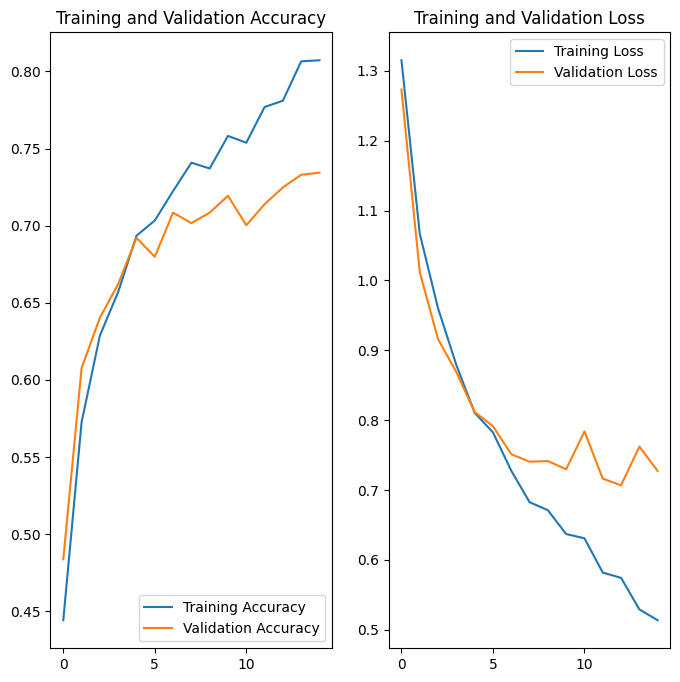

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

117948/117948 [==============================] - 0s 0us/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 252ms/step


This image most likely belongs to sunflowers with a 99.89 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmplopz6g0i/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmplopz6g0i/assets


2023-10-27 06:07:58.906962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-27 06:07:58.906999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 11, Total Ops 23, % non-converted = 47.83 %
 * 11 ARITH ops

- arith.constant:   11 occurrences  (f32: 10, i32: 1)



  (f32: 3)
  (f32: 2)
  (f32: 3)
  (f32: 1)


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.89 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

3.8146973e-06


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).